# Fire Pulse Analysis
Last update: 18 Sept 2017

**Synopsis:** This ipython notebook will read in fire pulse data sets for processing and analysis.  The data will be normalized and time aligned.  

**Abstract:** Fire pulse data taken from various tests was processed and analyzed to show the similarity of the characteristics of fire pulse from the UCHFS1000 fire set (Uresk Consulting HARM Fire Set 1000) firing into a LEEFI during Neyer threshold testing, compared to the NAWC FTSA when firing into a CVR for qualification and acceptance testing.  The Three fire pulses were analyzed. All the fire pulses were taken at ambient temperature. These are:
- FIRE_800V:  The highest stimulus successful fire pulse from the Neyer tests.
- FIRE_720V: The lowest stimulus successful fire pulse from the Neyer tests.
- CVR_Fire_Pulse: A sample of the FTSA fire pulse taken during acceptance testing measured on a CVR.

**Introduction:**  The purpose of this analysis is to show that the current viewing resistor (CVR) used for acceptance and qualification testing represents an adequate load that simulates a low energy exploding foil initiator (LEEFI).  The LEEFI is an explosive device that accepts a high voltage impulse from the rapid discharge of a capacitor and initiates a detonation wave used to initiate a secondary explosive device or that is propagated down a detonation cord.  This analysis will compare the peak amplitude of the stimulus pulse and the rise time measured during the explosive initiation reliability tests to the fire pulse measured into a CVR.  A LEEFI is a one time use explosive device and cannot be used for normal testing of the fight termination safe and arm (FTSA).  This analysis will show that the CVR is a suitable substitute for the LEEFI when performing functional tests of the FTSA.

**Scope:**  The data analyzed was taken at ambient temperature.  Data at hot (81°C) and cold (-54°C) temperatures was not made available for this analysis.  While the data is different at hot and cold temperatures the results will be similar in so far as the pulse shape should track with temperature. 

**Analysis method:**  The method presented here to establish that the CVR represents an actual LEEFI is to compare shape of the leading edge of the fire pulse from data taken during the Neyer tests to data from a CVR.  First, the fire pulse data will be normalized and time aligned to the peak of the pulse.  The fire pulses will be plotted on a common graph so that the general shape of the data can be visually inspected.  Then the rise time of the leading edge of the fire pulse will be calculated from the data.  For this analysis the rise time is taken to be the time difference between the 10% and 90% points on the leading edge of the pulse.  Finally the root-mean-square error (RMSE) will be computed between the normalized FIRE_800V data set and the other data sets to measure the degree of correlation.  If the fire pulses are highly correlated, we can conclude that the CVR represents a realistic load and is suitable for use during testing.

**General background:**
The FTSA is an electronic module that includes various safety features as well as the high voltage circuitry needed to charge the firing capacitor to about 1000 volts.  When a fire command is received, the high voltage capacitor is discharged into the LEEFI to initiate the explosive event.  
The LEEFI is a device that consists of a metal foil element, a layer of an insulating film and an explosive pellet.  When the capacitor discharges through the metal foil, a large amount of energy is deposited at very fast rate into the foil, the current heats the foil bridge through the melting, boiling and vaporization phases up to the plasma state, giving off thermal energy and shock waves. The insulating film is sheared off and accelerated to very high speed which impacts and detonates the explosive pellet.  A low inductive circuit is required to achieve a fast energy rise time into the foil.  

The fire circuit in the FTSA can be modeled as a series R, L and C circuit, with R, L and C being the resistance, inductance and capacitance of the circuit.  In the FTSA fire circuit the capacitance is dominated by the value of the high voltage capacitor, 0.2uF.  The resistance is the dynamic resistance of the LEEFI, about 0.5 ohms.  The inductance of the circuit is about 10nH.  Values for the the equivalent circuit can be determined by examining the ringdown waveform.  
- The circuit is underdamped if: $C \lt \frac{4L}{R^2}$
- The the resonant frequency is: $\omega _d = \frac{1}{\sqrt{LC}}$
- The resonant frequencies is the frequency at which the response amplitude is a relative maximum.
Natural frequency is the frequency at which a system tends to oscillate in the absence of any driving or damping force. The smaller the circuit inductance is, the higher will be the natural frequency and the faster the rise time of the leading edge of the fire pulse.

Neyer D-Optimal tests were conducted to determine experimentally the mean stimulus and standard deviation required to initiate the explosive pellet.  The stimulus being the voltage level on the high voltage capacitor just prior to discharge.  

A CVR resistor is used to simulate the LEEFI during testing of the the FTSA.  Since it’s not practical or safe to use an actual LEEFI and there is no easy way to monitor the current rise time during testing when the LEEFI is installed, a special type of resistor is used in place of the LEEFI for testing. The value of the CVR is about 0.5 ohms, since this represents the dynamic resistance of the metal foil for testing.  The DC resistance of the metal foil is about 150 milliohms. When the capacitor is discharged, thousands of amps flow through the foil and the current path transitions from the solid metal conductor of the foil to a plasma before being interrupted by the open circuit of the burnt out foil.  The dynamic resistance can rise to several ohms during this transient event.  A CVR value of about 0.5 ohms represents a load that allows the current flow from the capacitor to reasonably match the LEEFI.

# Python code
The python programming language was used to analyze the fire pulse data.  Python is a widely used high-level programming language for general-purpose programming. It has a large and comprehensive standard library.

This python code is run from within a jupyter notebook.  A [Jupyter](http://jupyter.org/) notebook is an browser based application that allows you to create and share documents that contain live code, equations, visualizations and explanatory text. It is designed to make data analysis easier to share and reproduce.

## Load python packages
These packages are from the [SciPy](https://en.wikipedia.org/wiki/SciPy) Python library.  [SciPy](https://www.scipy.org/) is an open source Python library used for scientific computing and technical computing. SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering. 

In [79]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import scipy.fftpack
from scipy.signal import blackman
from scipy.signal import tukey
import scipy.stats as stats
import matplotlib.pyplot as plt

**Load fire pulse data from files:** Fire pulse data was captured by digital storage oscilloscopes and saved as comma separated value (CSV) files.  The files loaded here were previously sliced from much longer data sets.  Only the main body of the pulse is loaded plus a little bit of the waveform at either end.  The units for time are converted to ns for the analysis.
- FIRE_800V data set:  The original record length was 25,000 points with a sample interval of 8.00E-11 seconds.  About 5,000 points were sliced out and saved to form a reduced data set consisting of the fire pulse.
- FIRE_720V data set: The original record length was 5,000 points with a sample interval of 4E-10 seconds.
- The CVR_ data set:  The original record length was 100,000 points with a sample interval of 1ns.


In [80]:
df1 = pd.read_pickle('FIRE_800V.pkl')
df2 = pd.read_pickle('FIRE_720V.pkl')
df3 = pd.read_pickle('FTSA Fire Pulse.pkl')

**Normalize and time align the data:** During the Neyer tests, the stimulus level, the voltage on the capacitor, was adjusted according to the test algorithm.  In order to compare the fire pulse from the CVR to the LEEFI fire pulses, the data was normalized because the voltage levels were in each case different.  The data was then time aligned to the peak and the time index was adjusted to set t = 0 at the peak.

In [81]:
# FIRE 800V, read the data file
x1 = df1['Time'].values
y1 = df1['Voltage'].values

In [82]:
# display some info about the data set
n = len(x1)
dt = x1[1]-x1[0]
print('length of data set: {:d} samples'.format(n))
print('time step: {:.1f} ps'.format(dt*1e12))
print('data capture interval: {:.1f} ns'.format(n*dt*1e9))
print('sample frequency: {:,.1f} GHz'.format(1e-9/dt))
print('Nyquist frequency: {:,.1f} GHz'.format(1e-9/dt/2))
print('peak value: {:.3f} volts'.format(y1.max()))

length of data set: 7500 samples
time step: 80.0 ps
data capture interval: 600.0 ns
sample frequency: 12.5 GHz
Nyquist frequency: 6.3 GHz
peak value: 1.060 volts


In [83]:
# normalize and time align to peak @ t=0
y1 = y1/y1.max()
x1 *= 1e9 #convert to ns
y1_peak_index = y1.argmax()
x1 -= x1[y1_peak_index]

In [84]:
# FIRE 720V, read the data file
x2 = df2['Time'].values
y2 = df2['Voltage'].values

In [85]:
# display some info about the data set
n = len(x2)
dt = x2[1]-x2[0]
print('length of data set: {:d} samples'.format(n))
print('time step: {:.1f} ps'.format(dt*1e12))
print('data capture interval: {:.1f} ns'.format(n*dt*1e9))
print('sample frequency: {:,.1f} GHz'.format(1e-9/dt))
print('Nyquist frequency: {:,.1f} GHz'.format(1e-9/dt/2))
print('peak value: {:.3f} volts'.format(y2.max()))

length of data set: 1500 samples
time step: 400.0 ps
data capture interval: 600.0 ns
sample frequency: 2.5 GHz
Nyquist frequency: 1.2 GHz
peak value: 0.956 volts


In [86]:
# normalize and time align to peak @ t=0
y2 = y2/y2.max()
x2 *= 1e9 #convert tp ns
y2_peak_index = y2.argmax()
x2 -= x2[y2_peak_index]

In [87]:
# CVR Fire Pulse, read the data file
x3 = df3['Time'].values
y3 = df3['Voltage'].values

In [88]:
# display some info about the data set
n = len(x2)
dt = x3[1]-x3[0] # time interval is in ns
print('length of data set: {:,d} samples'.format(n))
print('time step: {:.1f} ns'.format(dt))
print('data capture interval: {:,.1f} ns'.format(n*dt))
print('sample frequency: {:,.1f} GHz'.format(1/dt))
print('Nyquist frequency: {:,.1f} GHz'.format(1/dt/2))
print('peak value: {:.1f} volts'.format(y3.max()))

length of data set: 1,500 samples
time step: 1.0 ns
data capture interval: 1,500.0 ns
sample frequency: 1.0 GHz
Nyquist frequency: 0.5 GHz
peak value: 11.2 volts


In [89]:
# normalize and time align to peak @ t=0
y3 = y3/y3.max()
y3_peak_index = y3.argmax()+5 #add 5 samples because argmax didn't detect the peak
x3 -= x3[y3_peak_index]

**Plot the data:** Each of the pulses is plotted to make sure the time alignment and normalization look correct.

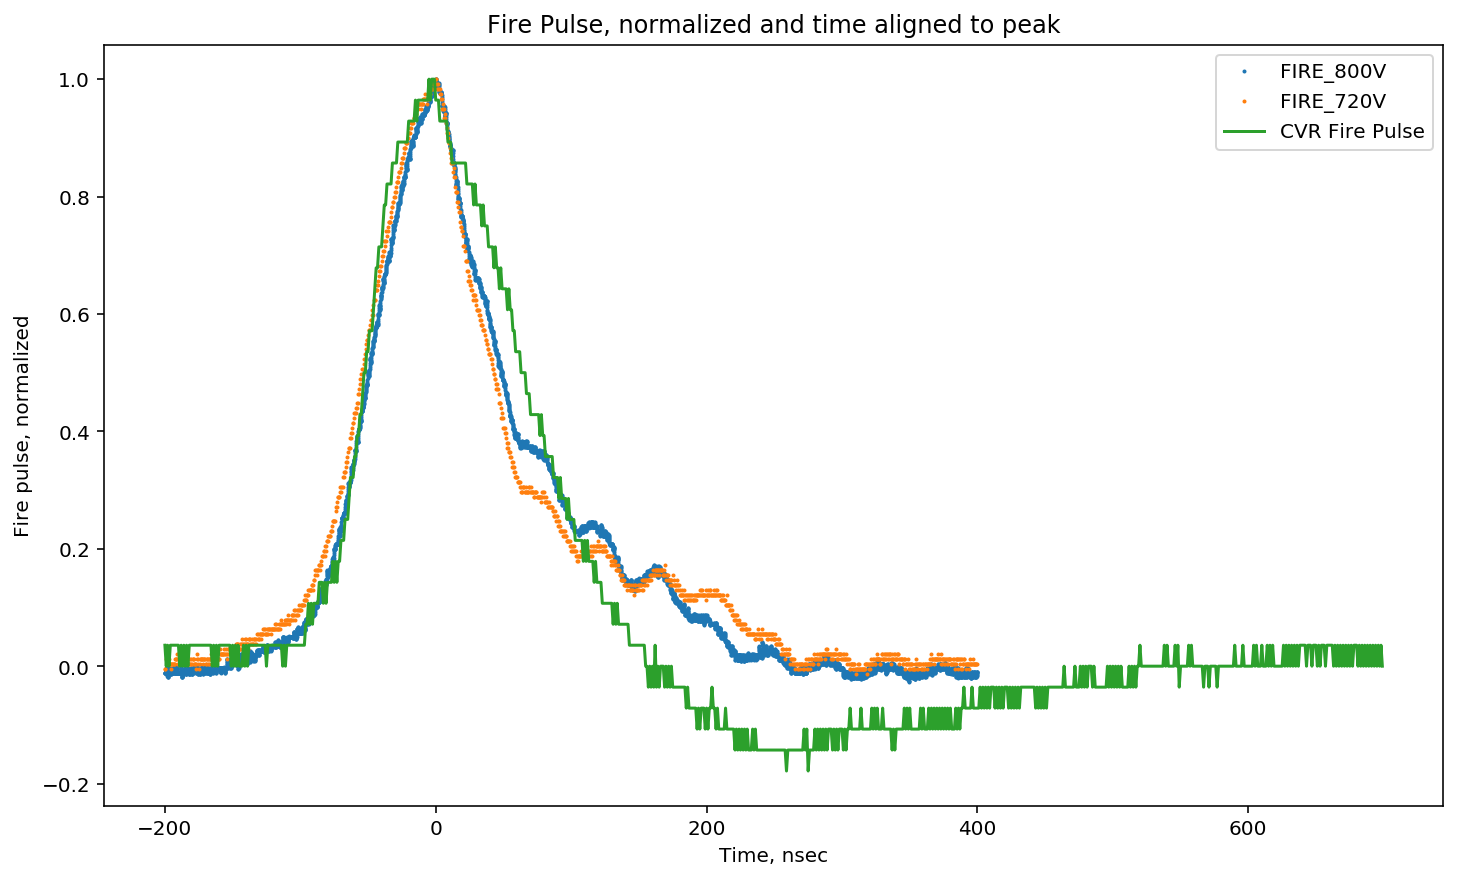

In [90]:
# plot the fire pulse
plt.plot(x1,y1,'o', markersize=1)
plt.plot(x2,y2,'o', markersize=1)
#plt.plot(x3,y3,'o', markersize=1)
plt.plot(x3,y3)
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse, normalized')
plt.legend(['FIRE_800V', 'FIRE_720V', 'CVR Fire Pulse'], loc='best')
plt.title('Fire Pulse, normalized and time aligned to peak')
plt.show()

**Plotting only the leading edge of the fire pulses:** The leading edge of the pulse along with the amplitude are the critical features of the fire pulse.  In this analysis we want to show that the fire pulse obtained from the CVR has a similar rise time to fire pulses from the Neyer tests.  The data for FIRE_720V and the CVR fire pulse was a little noisy so all the data sets were smoothed when calculating the rise time of the leading edge of the pulse.  The voltage resolution on the CVR_test was about 0.4 volts and the lack of resolution required smoothing to obtain accurate results.

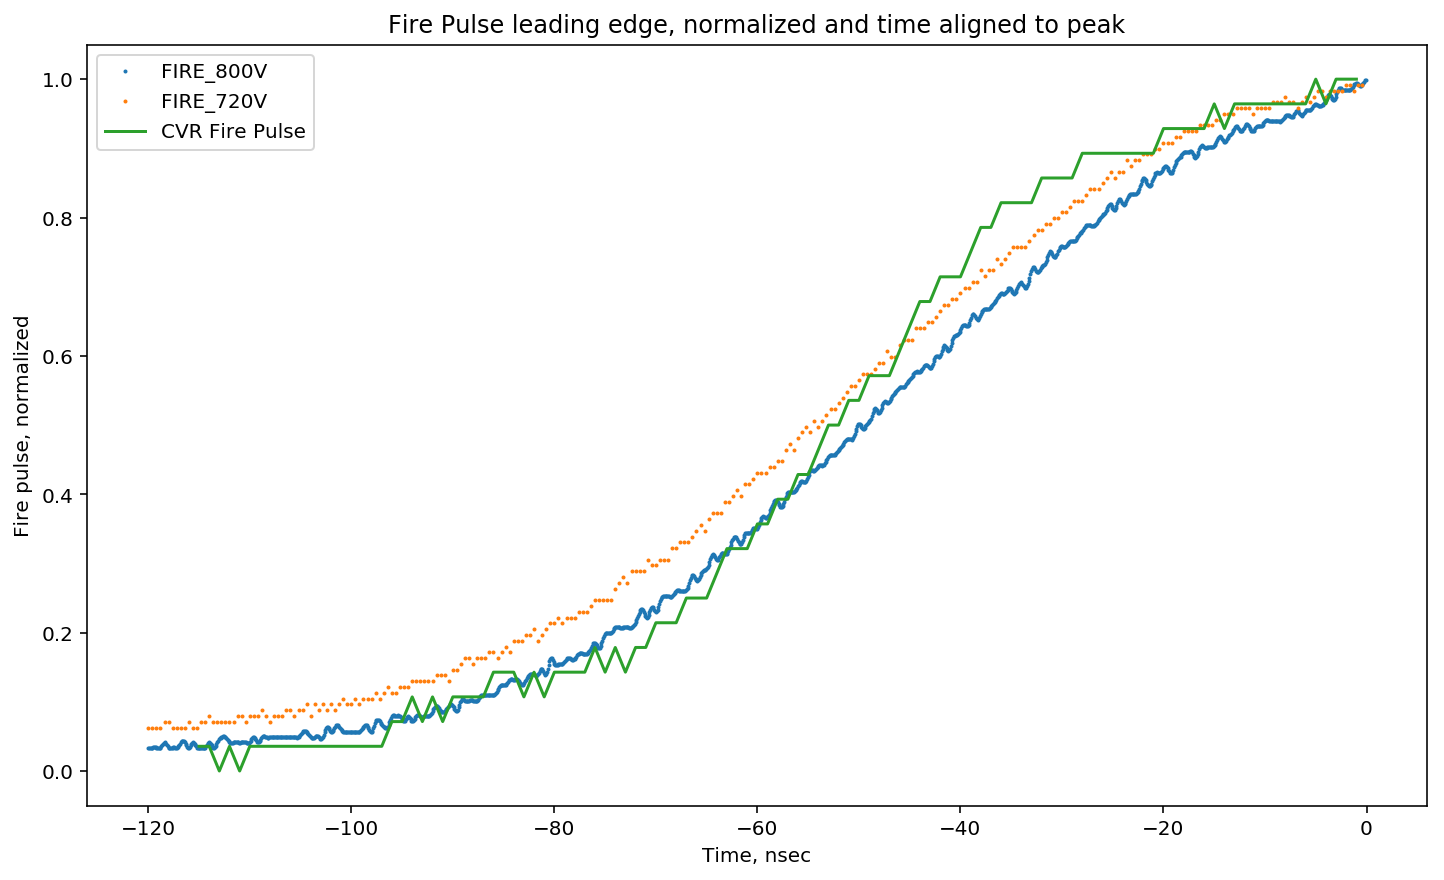

In [91]:
# plot the fire pulse
plt.plot(x1[y1_peak_index-1500:y1_peak_index],y1[y1_peak_index-1500:y1_peak_index],'o', markersize=1)
plt.plot(x2[y2_peak_index-300:y2_peak_index],y2[y2_peak_index-300:y2_peak_index],'o', markersize=1)
#plt.plot(x3[y3_peak_index-120:y3_peak_index],y3[y3_peak_index-120:y3_peak_index],'o', markersize=1)
plt.plot(x3[y3_peak_index-115:y3_peak_index],y3[y3_peak_index-115:y3_peak_index])
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse, normalized')
plt.legend(['FIRE_800V', 'FIRE_720V', 'CVR Fire Pulse'], loc='best')
plt.title('Fire Pulse leading edge, normalized and time aligned to peak')
plt.show()

**Calculate rise time:** The rise time will be calculated on the smoothed data set. A Savitzky–Golay filter was be used to smooth the data.

A [Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the signal-to-noise ratio without greatly distorting the signal. This is achieved, in a process known as convolution, by fitting successive subsets of adjacent data points with a low-degree polynomial by the method of linear least squares.

Comparison of the pulse leading edges:  Rise times of the leading edge of the fire pulses were calculated.  The rise time ranged from 59 to 79 ns.  The shape of the leading edges of the pulses were compared to each other.    The CVR_test data had a faster rise time presumably since the FIRE_800V and FIRE_720V tests included extra inductance from the strip line extension used during the Neyer tests.  Time t=0 is at the peak of the pulse and the time is negative prior to the peak.

**Rise time for FIRE_800V**

In [92]:
# consider only the rising edge
x1_rise = x1[y1_peak_index-1500:y1_peak_index]
y1_rise = y1[y1_peak_index-1500:y1_peak_index]

y1_filtered = savgol_filter(y1_rise, 51, 3)  # filter the data

index_90pc = (np.abs(y1_filtered-y1_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y1_filtered-y1_filtered.max()*0.1)).argmin()
rise_time = x1_rise[index_90pc]-x1_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y1_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y1_filtered[index_90pc], x1_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y1_filtered[index_10pc], x1_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.997 volts
90% voltage value: 0.897 volts at -16 ns
10% voltage value: 0.099 volts at -89 ns
rise time: 72 ns


Plot the 90% and 10% points on the curve:  Plotting the data to make sure the data points look correct.

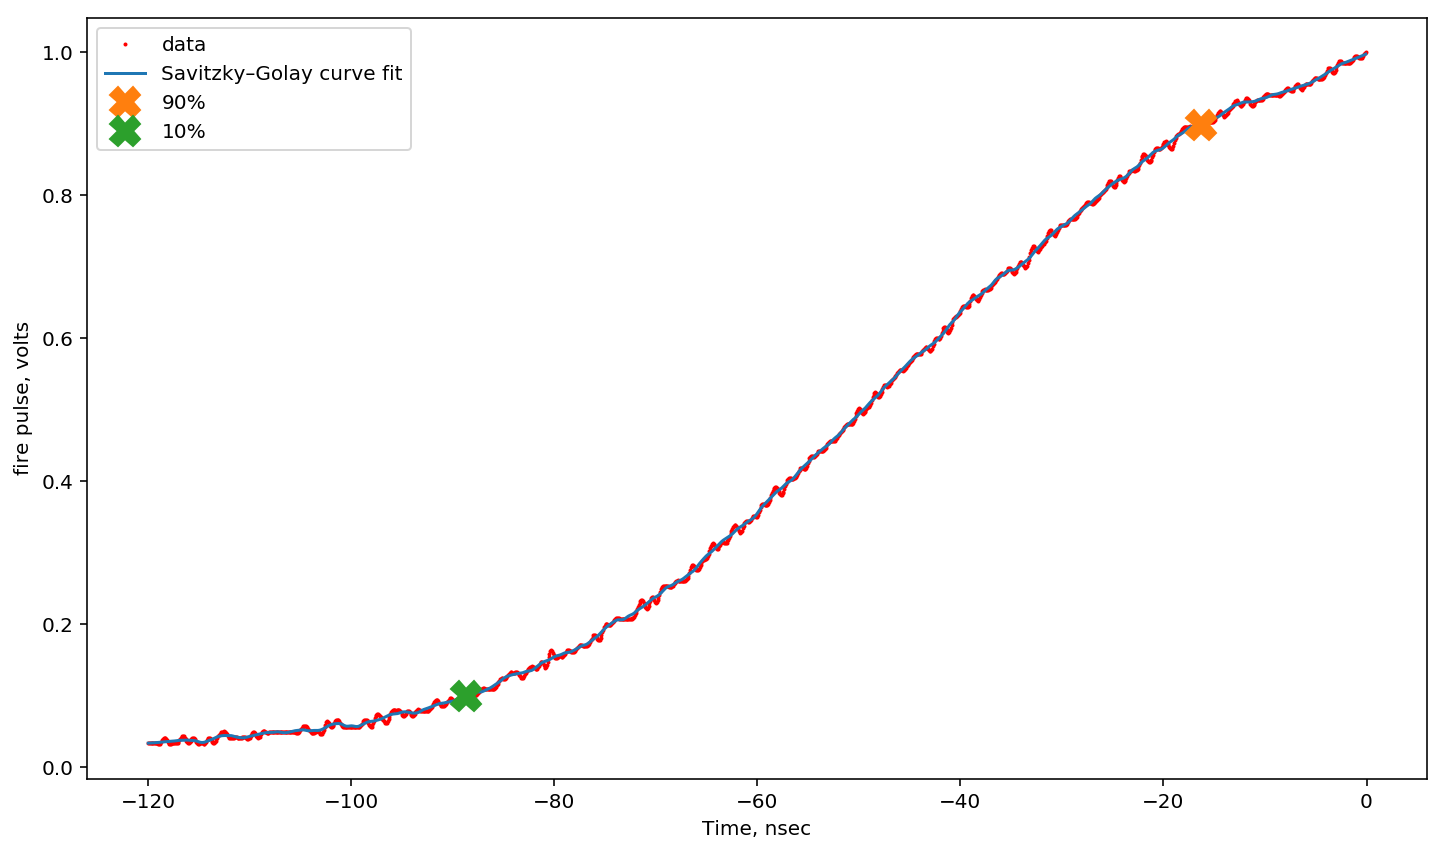

In [93]:
plt.plot(x1_rise,y1_rise,'ro', markersize=1)
plt.plot(x1_rise,y1_filtered)
plt.plot(x1_rise[index_90pc],y1_filtered[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x1_rise[index_10pc],y1_filtered[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

**Rise time for FIRE_720V**

In [94]:
# consider only the rising edge
x2_rise = x2[y2_peak_index-300:y2_peak_index]
y2_rise = y2[y2_peak_index-300:y2_peak_index]

y2_filtered = savgol_filter(y2_rise, 51, 3)  # filter the data
index_90pc = (np.abs(y2_filtered-y2_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y2_filtered-y2_filtered.max()*0.1)).argmin()
rise_time = x2_rise[index_90pc]-x2_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y2_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y2_filtered[index_90pc], x2_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y2_filtered[index_10pc], x2_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.993 volts
90% voltage value: 0.895 volts at -21 ns
10% voltage value: 0.099 volts at -100 ns
rise time: 79 ns


Plot the 90% and 10% points on the curve

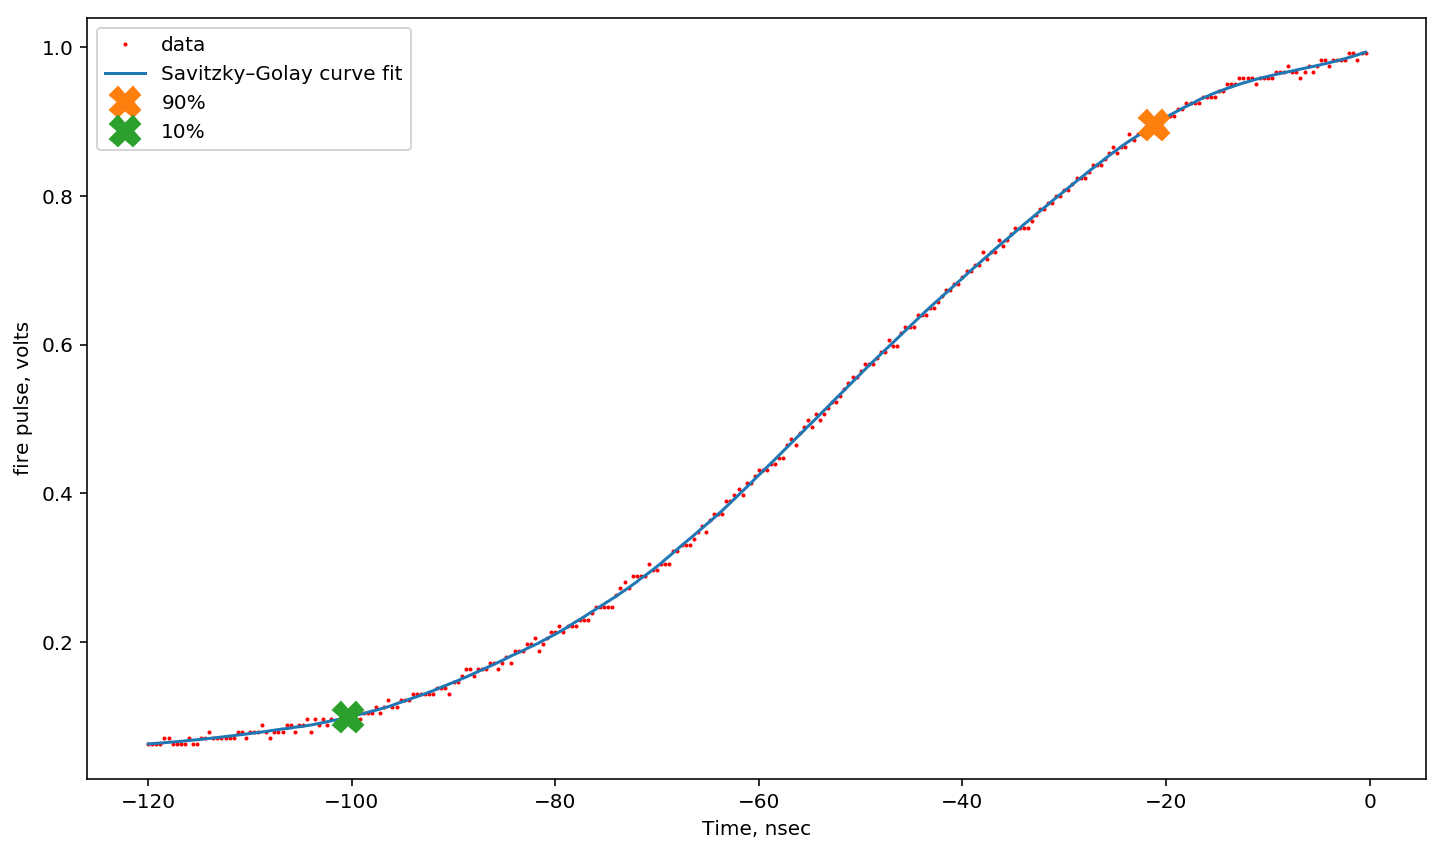

In [95]:
plt.plot(x2_rise,y2_rise,'ro', markersize=1)
plt.plot(x2_rise,y2_filtered)
plt.plot(x2_rise[index_90pc],y2_filtered[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x2_rise[index_10pc],y2_filtered[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

**Rise time for CVR fire pulse**

In [96]:
# consider only the rising edge
x3_rise = x3[y3_peak_index-120:y3_peak_index]
y3_rise = y3[y3_peak_index-120:y3_peak_index]

y3_filtered = savgol_filter(y3_rise, 51, 3)  # filter the data

index_90pc = (np.abs(y3_filtered-y3_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y3_filtered-y3_filtered.max()*0.1)).argmin()
rise_time = x3_rise[index_90pc]-x3_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y2_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y3_filtered[index_90pc], x3_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y3_filtered[index_10pc], x3_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.993 volts
90% voltage value: 0.901 volts at -24 ns
10% voltage value: 0.101 volts at -87 ns
rise time: 63 ns


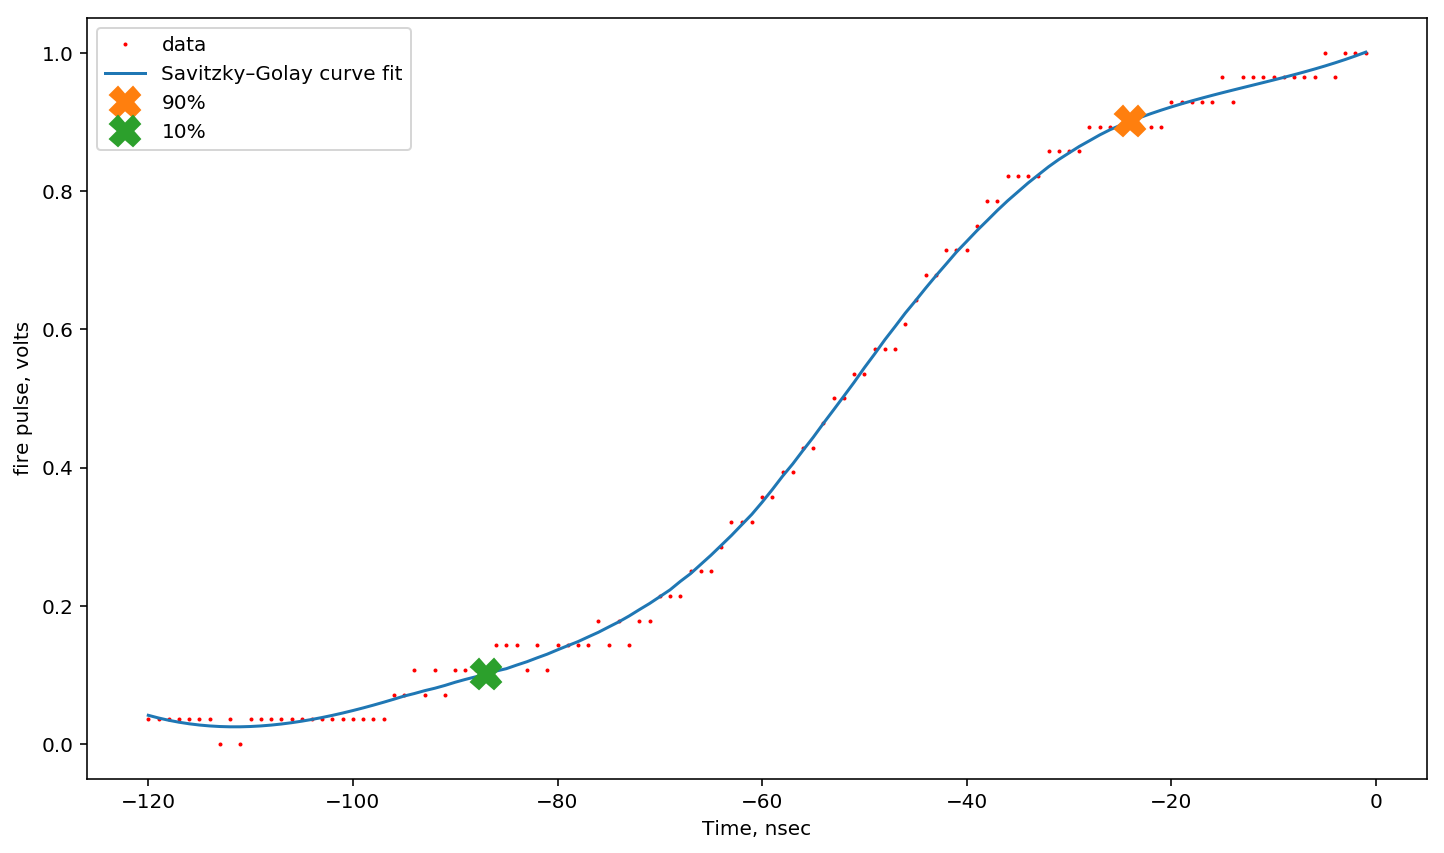

In [97]:
plt.plot(x3_rise,y3_rise,'ro', markersize=1)
plt.plot(x3_rise,y3_filtered)
plt.plot(x3_rise[index_90pc],y3_filtered[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x3_rise[index_10pc],y3_filtered[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

**Comparison of the pulse leading edges:**  Rise times of the leading edge of the fire pulses were calculated.  The rise time ranged from 59 to 79 ns.  The shape of the leading edges of the pulses were compared to each other.    The CVR_test data had a faster rise time presumably since the FIRE_800V and FIRE_720V tests included extra inductance from the strip line extension used during the Neyer tests.  Time t=0 is at the peak of the pulse and the time is negative prior to the peak.

**Numerical comparison of the fire pulse's leading edges:** A simple way to compare two data sets is to plot and visually examine them, which was done above.  This requires one to make a subjective judgement as to how close two data sets are.  In this section, I’m looking for a numerical way to compare two data sets.

**Polynomial fit to the FIRE 800V rising edge data:** First thing is to pick the FIRE_800V as the reference dataset.  I chose this data set to be the reference because it was taken at the highest stimulus level and therefore closer to the FTSA charge value.  It also has the most data points.  The polynomial fit to the FIRE_800V is shown below.  As you can see the curve is a good fit to the data over the leading edge interval. A polynomial fit of the reference dataset is needed because the data sets for the other fire pulses are different lengths and polynomial can be used to generate points from the reference function so that the data sets are of equal lengths for comparison.

In [98]:
z = np.polyfit(x1_rise, y1_rise, 5)
fx = np.poly1d(z) # convert it to a function
print(fx)

           5             4            3             2
1.923e-10 x + 4.588e-08 x + 2.07e-06 x - 0.0001198 x + 0.003231 x + 0.9864


Polynomial fit to the FIRE 800V rising edge data: A 5th order fits nice over the interval.  Regression Analysis can be used when trying to fit data to a linear model.  The FIRE_800V is best modeled by a 5th order polynomial as shown in the plot below. So linear regression analysis is probably not the way to go.

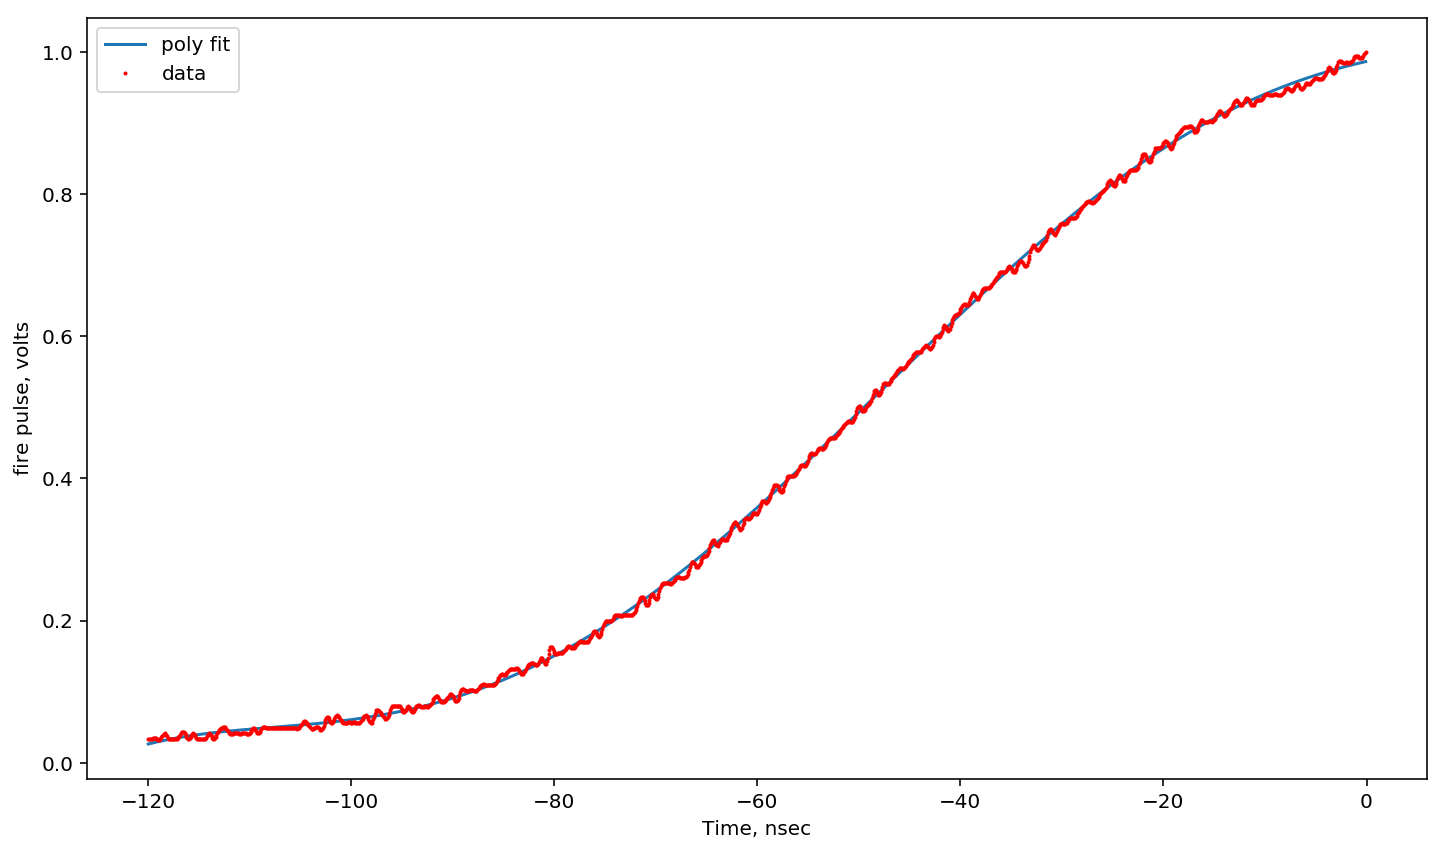

In [99]:
#plot the polynomial and the data
xp = np.linspace(x1_rise[0], x1_rise[-1], 500)
plt.plot(xp, fx(xp), '-')
plt.plot(x1_rise,y1_rise,'ro', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['poly fit', 'data'], loc='best')
plt.show()

This plot is the residuals of the polynomial fit.  Each residual is the measure of the deviation of value of an element from the polynomial reference curve. The residuals are small and random as is expected since the polynomial coefficients were generated by the curve fitting algorithm to have a least squared error fit.  A histogram of the residuals, plotted along with a normal distribution curve for the data is shown.  This also shows that the polynomial is an good fit to the data from which it was generated from.

In [100]:
#Residuals
xp = np.linspace(x1_rise[0], x1_rise[-1], len(y1_rise))
y1_residuals = fx(xp) - y1_rise

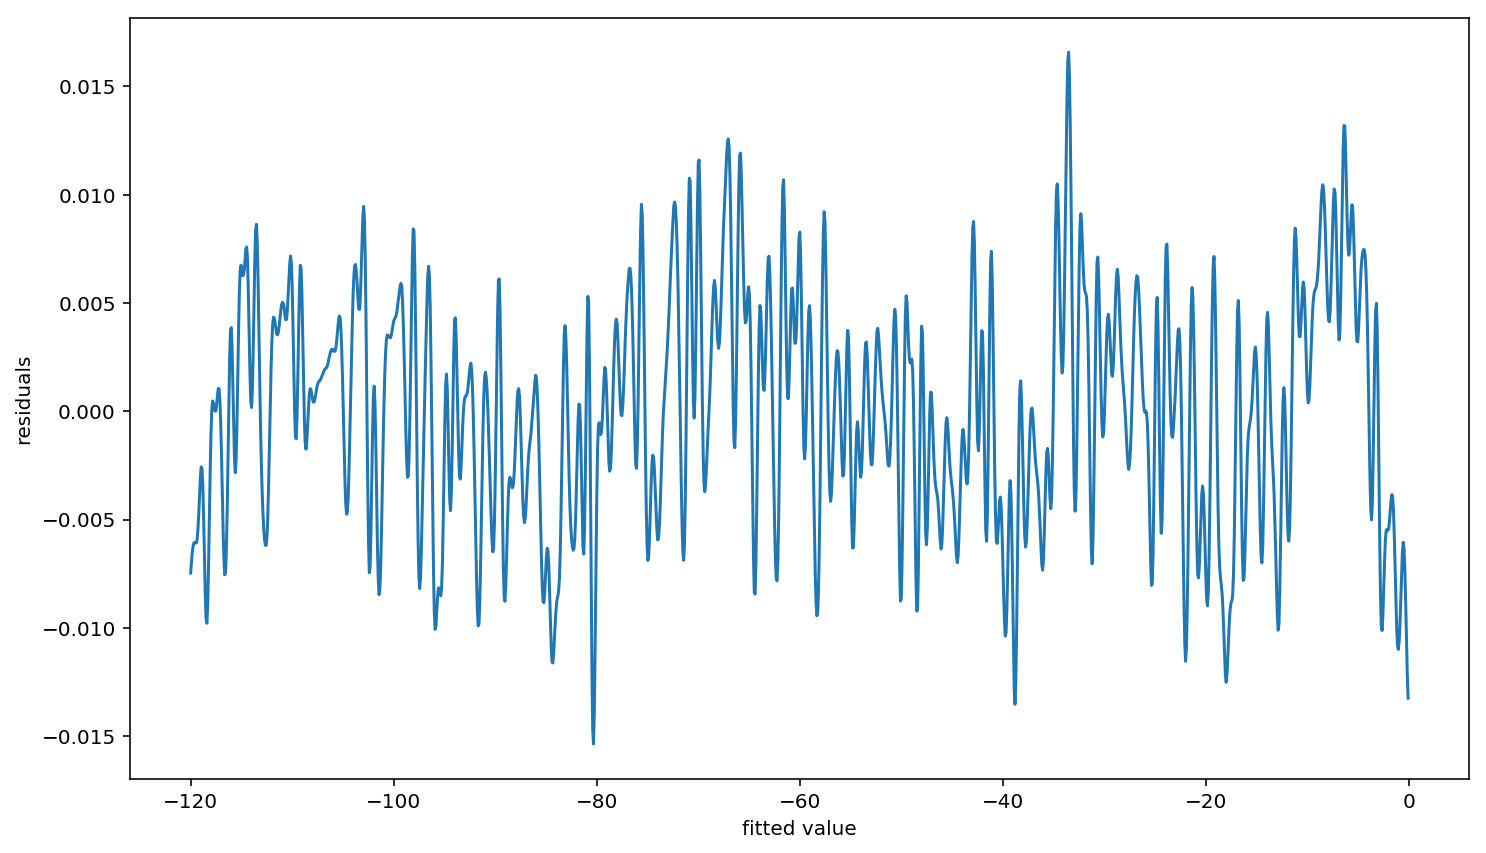

In [101]:
#plot the residuals
plt.plot(xp, y1_residuals, '-')
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [102]:
y1_residuals.sort()
fit_y1 = stats.norm.pdf(y1_residuals, np.mean(y1_residuals), np.std(y1_residuals))

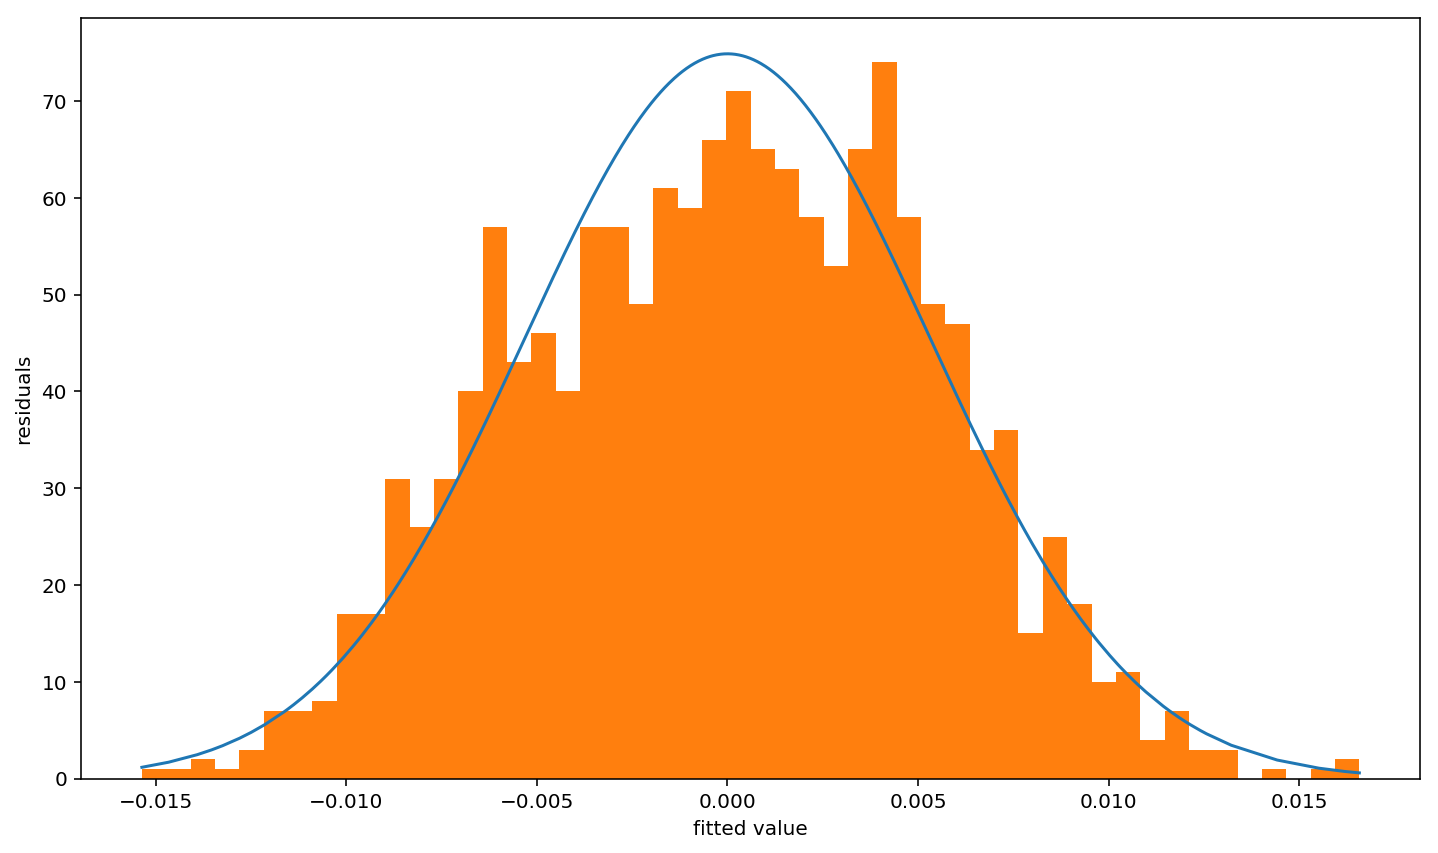

In [103]:
#plot the residuals
plt.plot(y1_residuals, fit_y1)
plt.hist(y1_residuals,bins=50)
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [104]:
#Residuals
xp = np.linspace(x2_rise[0], x2_rise[-1], len(y2_rise))
y2_residuals = fx(xp) - y2_rise

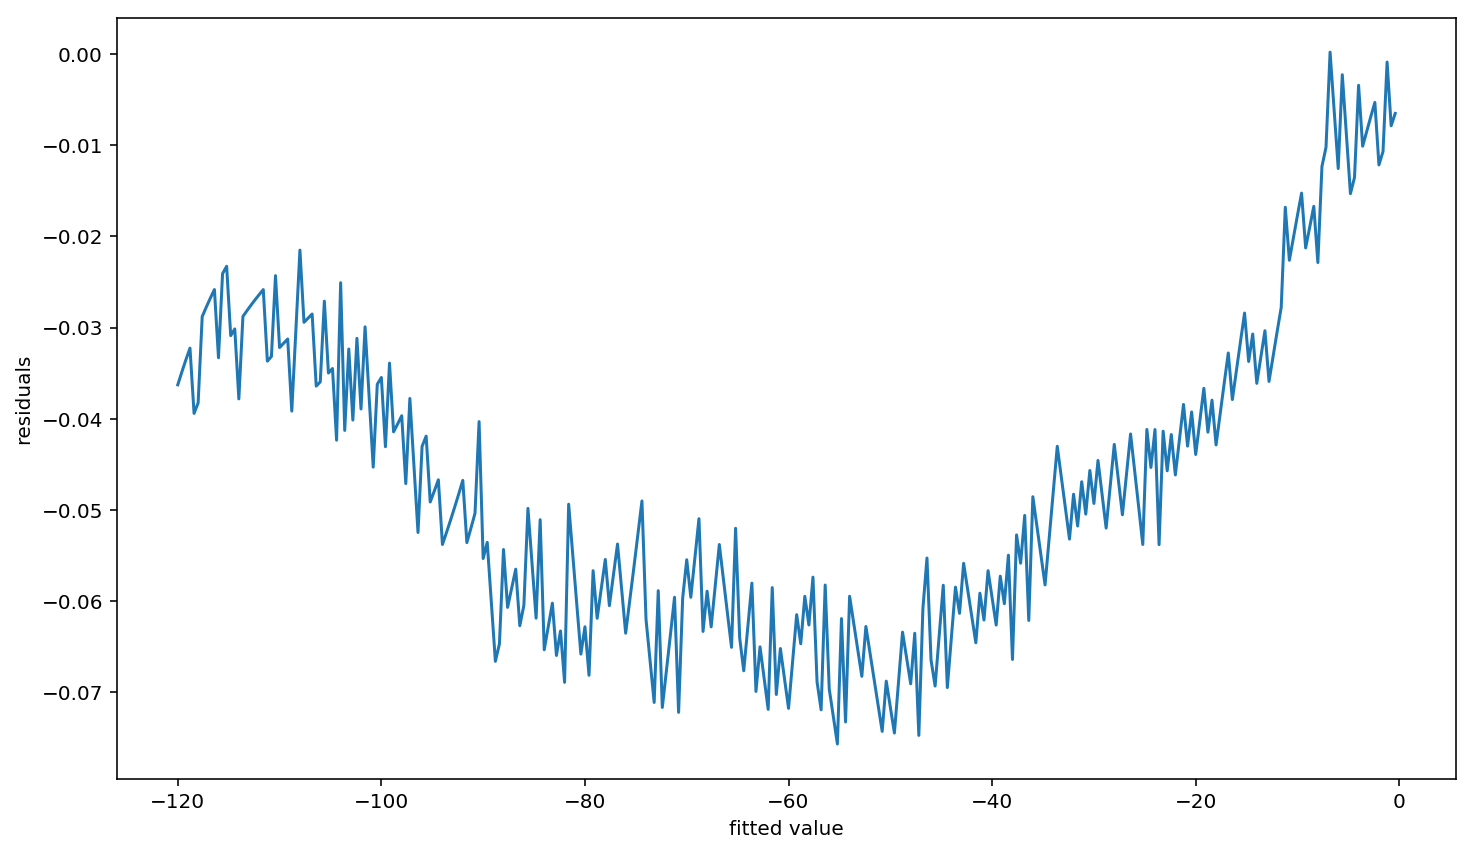

In [105]:
#plot the residuals
plt.plot(xp, y2_residuals, '-')
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [106]:
y2_residuals.sort()
fit_y2 = stats.norm.pdf(y2_residuals, np.mean(y2_residuals), np.std(y2_residuals))

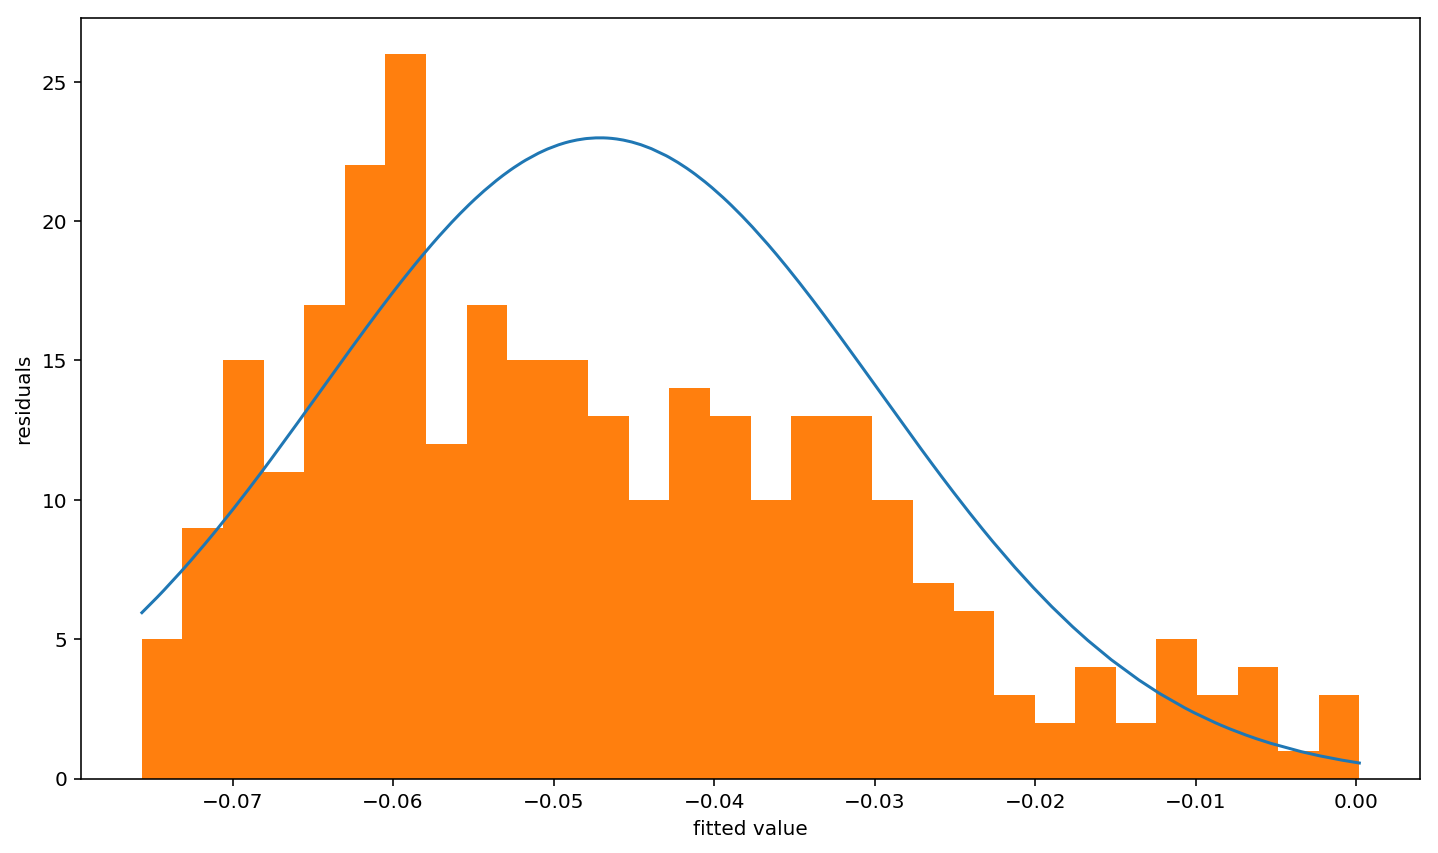

In [107]:
#plot the residuals
plt.plot(y2_residuals, fit_y2)
plt.hist(y2_residuals,bins=30)
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [108]:
np.mean(y2_residuals)

-0.04711829549005149

Examine the residuals for CVR_fire_pulse

In [109]:
#Residuals
xp = np.linspace(x3_rise[0], x3_rise[-1], len(y3_rise))
y3_residuals = fx(xp) - y3_rise

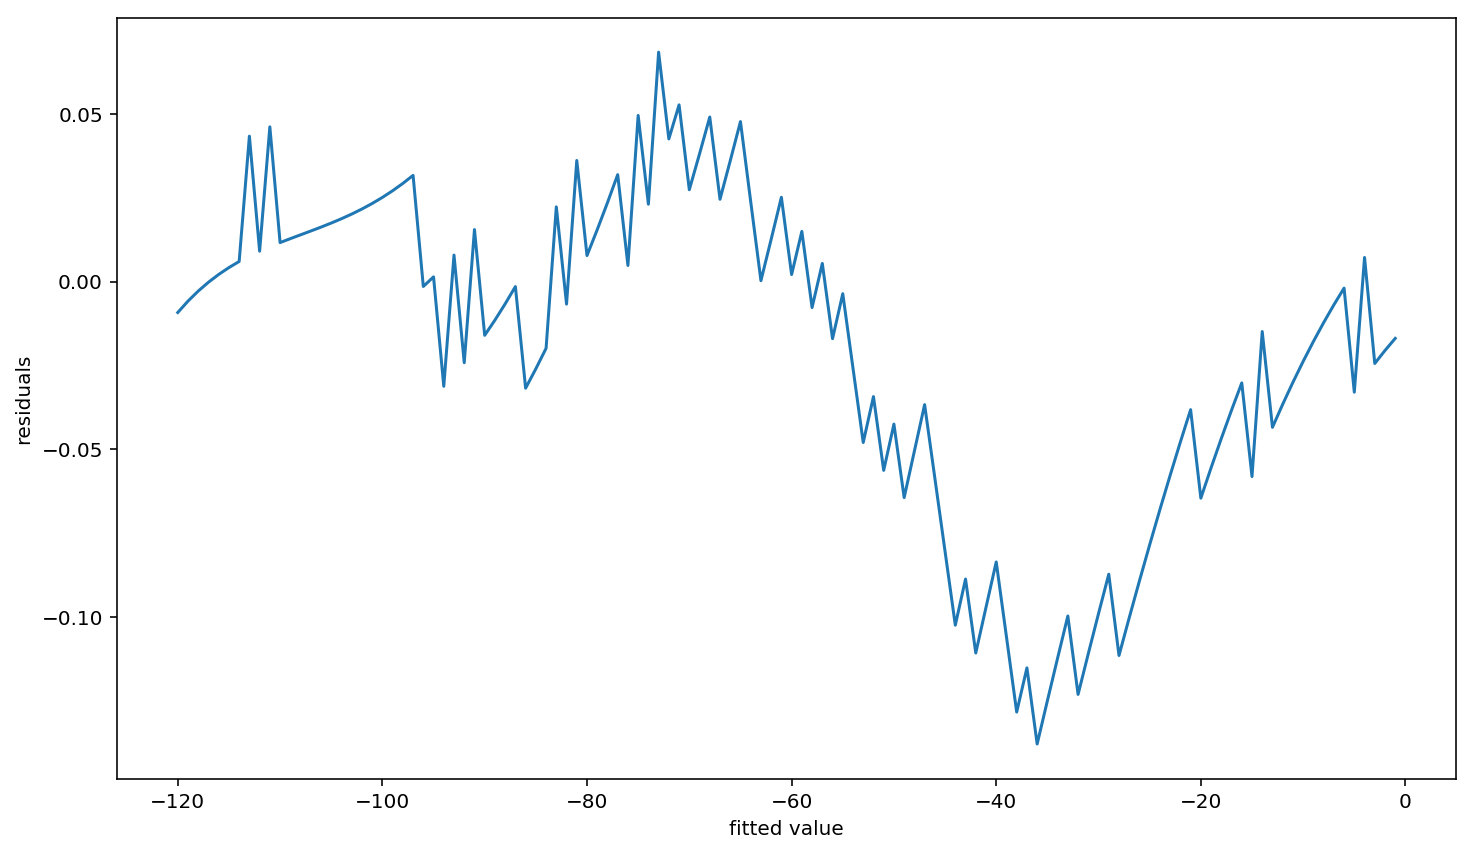

In [110]:
#plot the residuals
plt.plot(xp, y3_residuals, '-')
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [111]:
y3_residuals.sort()
fit_y3 = stats.norm.pdf(y3_residuals, np.mean(y3_residuals), np.std(y3_residuals))

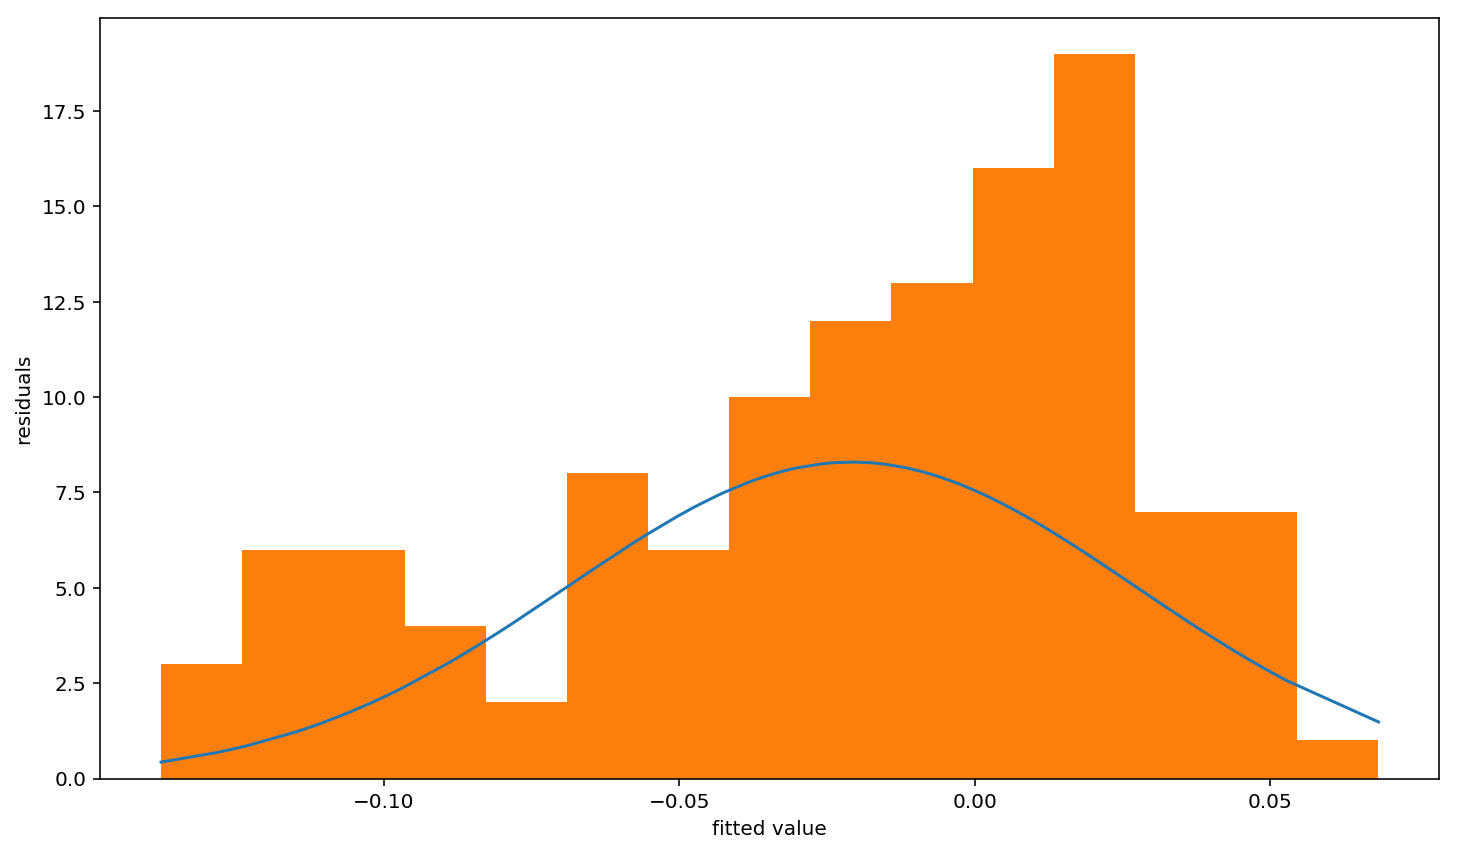

In [112]:
#plot the residuals
plt.plot(y3_residuals, fit_y3)
plt.hist(y3_residuals,bins=15)
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [113]:
np.mean(y3_residuals)

-0.020855994741993542

Checking the residual plots of the other datasets against the reference polynomial, we see that the errors are small.  However there regions along the curve that are systematically over and under-predicted.  The FIRE_720V data set  shows a small bias error along the full data set.  The histogram also shows this bias error and the shape of the histogram does not follow the normal probability distribution.  This might indicate that from a sample of two LEEFI data sets there differences and to arbitrarily pick one as the reference is not that useful.  In any case the errors are small and a visual examination of the plots shows that the data is similar.  The residuals from the CVR_fire_pulse data set are also very small and the distribution is somewhat normal looking.  From these plots we can conclude that there are no outlying data points that can cause any concerns when making a judgment as to how close the CVR fire pulse matches the LEEFI fire pulses from the Neyer testing.

**Calculate the root-mean-square error (RMSE):** Calculate the root-mean-square error (RMSE): The RMSE is the square root of the average of squared errors. The following code cells use the FIRE 800V fire pulse as the reference fire pulse and compares a curve fit of the FIRE 800V pulse to the FIRE 720V and CVR fire pulses.

In [114]:
# function to calculate the rmse
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Using FIRE_800V as the reference, calculate the rmse between FIRE_800V and itself, just the RMSE edge segment of the pulse.

In [115]:
rmse(y1_rise, y1_rise)

0.0

Calculate the RMSE between FIRE_800V and the polynomial fit to FIRE_800V:  These two are a close match because they are from the same data set.  The RMSE error is 0.005.

In [116]:
xp = np.linspace(x1_rise[0], x1_rise[-1], len(y1_rise))
rmse(y1_rise, fx(xp))

0.005327652281802567

Calculate the RMSE between FIRE_720V and the polynomial fit to FIRE_800V:  The RMSE error is 0.050.

In [117]:
xp = np.linspace(x2_rise[0], x2_rise[-1], len(y2_rise))
rmse(y2_rise, fx(xp))

0.0502130803382283

Calculate the RMSE between CVR_fire_pulse and the polynomial fit to FIRE_800V: The RMSE error is 0.047.  The RMSE calculated is very small which agrees with the visual inspection of the plotted data.  In the next section I try to get an understanding of typical RMSE values for various test cases.

In [118]:
xp = np.linspace(x3_rise[0], x3_rise[-1], len(y3_rise))
rmse(y3_rise, fx(xp))

0.052409178809633174

**Some RMSE tests:** I couldn’t find any rules of thumb that say how low the RMSE should be for two data set to be considered a close match. Here is some test data with known differences and the calculated RMSE. The test data is based on 1/4 cycle of a sine wave, which is similar to the leading edge of the fire pulse.

Case 1: two sine waves, 180 degrees out of phase plus an increasing offset

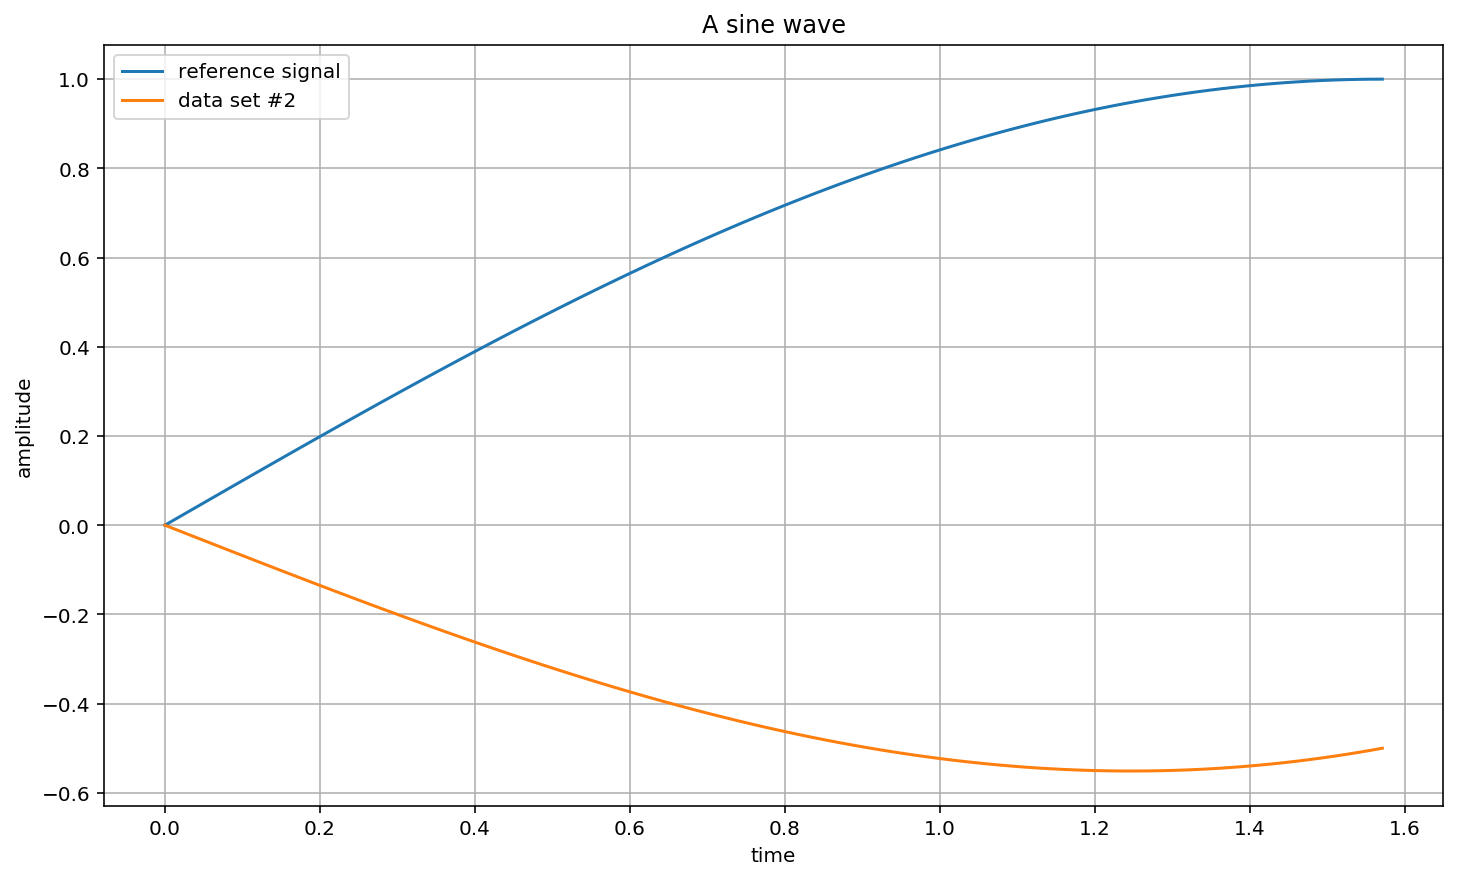

In [119]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = np.linspace(0.0, 0.5, 100)
phase = 180*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t+phase) + offset
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [120]:
rmse(ref_signal, ds2)

1.1275076935782502

Case 2: two sine waves, in phase plus an increasing offset

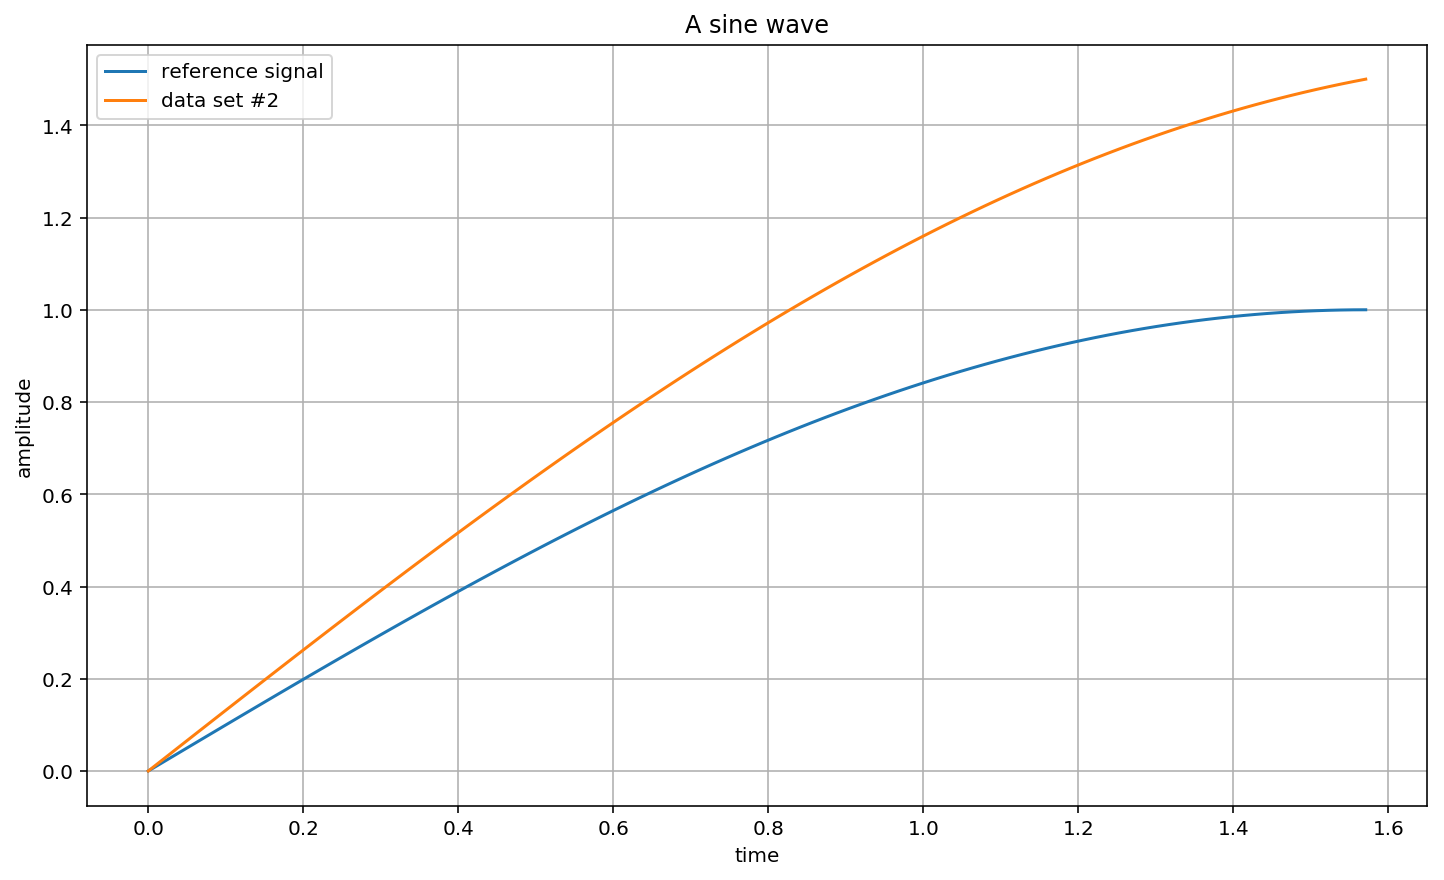

In [121]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = np.linspace(0.0, 0.5, 100)
phase = 0*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t+phase) + offset
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [122]:
rmse(ref_signal, ds2)

0.2894031940981453

Case 3: two sine waves, 10 degree phase error, no offset, with some noise

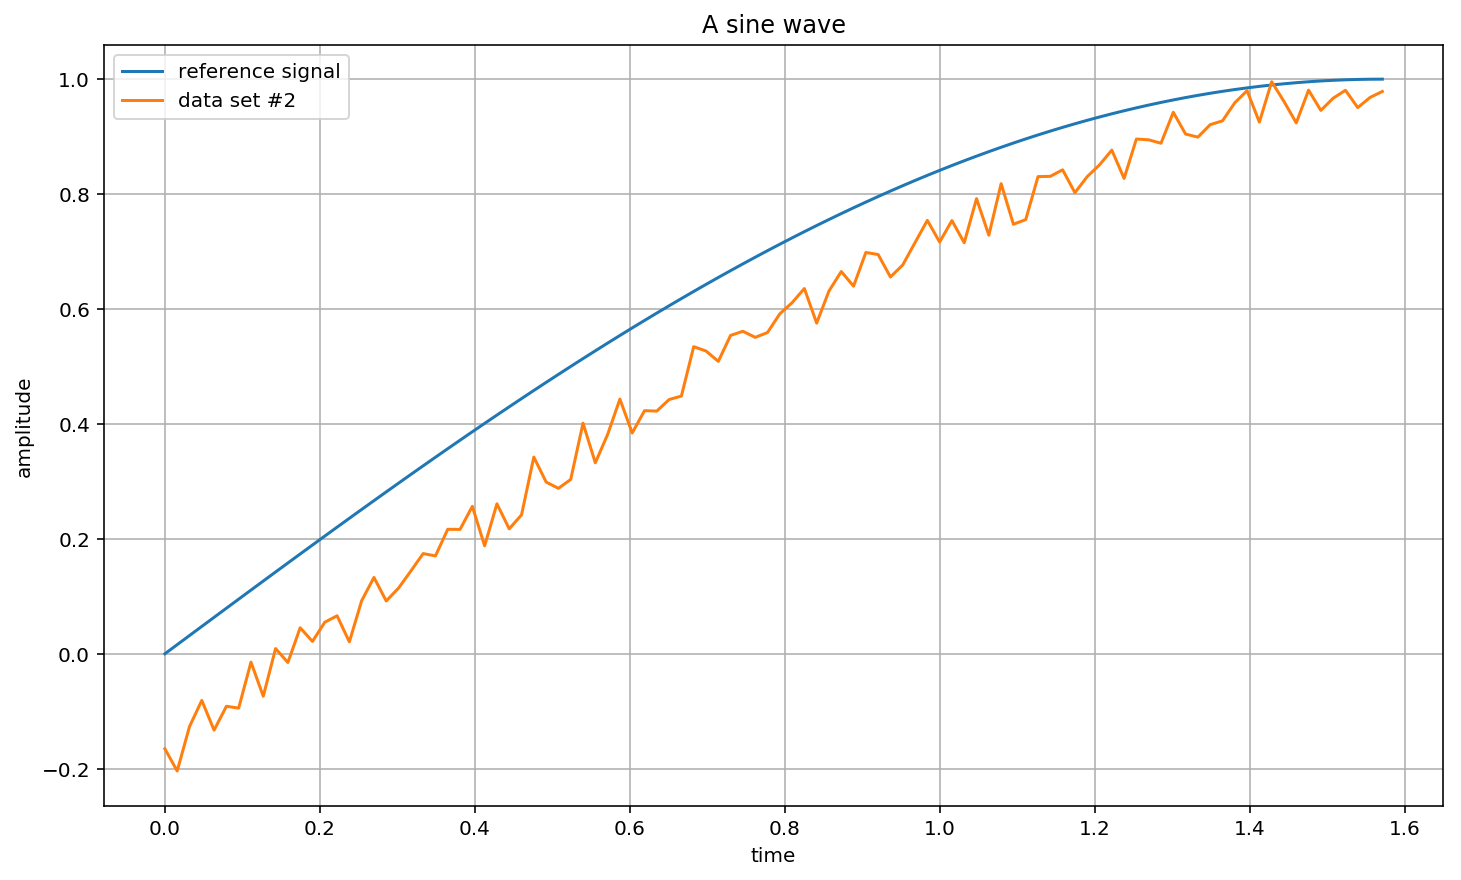

In [123]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = 0 #np.linspace(0.0, 0.5, 100)
noise = np.random.random_sample((100,)) - 0.5
phase = 10*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t-phase) + offset + noise*0.1
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [124]:
rmse(ref_signal, ds2)

0.13219974148990876

Case 4: two sine waves, 3 degrees of phase error, 0.1 offset, with some noise

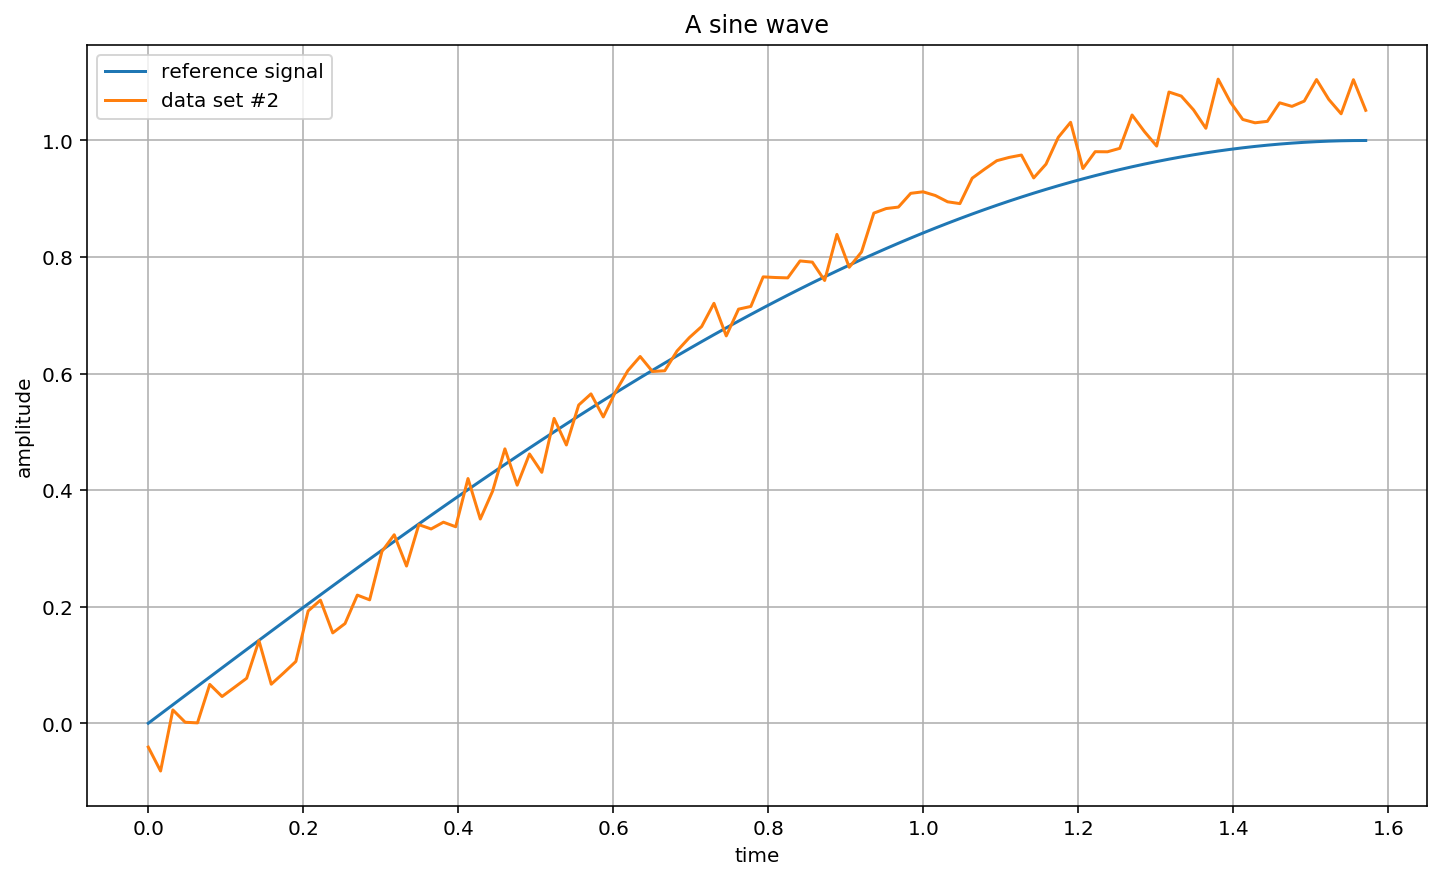

In [125]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = np.linspace(0.0, 0.1, 100)
noise = np.random.random_sample((100,)) - 0.5
phase = 3.0*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t-phase) + offset + noise*0.1
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [126]:
rmse(ref_signal, ds2)

0.055427008160630342

RMSE Conclusions: Test case 4 had only slight differences between the reference waveform and the test data set. The RMSE was calculated to be 0.05. I think we can conclude that if the RMSE is less than 0.05, the correlation between the data sets is good. Visual inspection of the plotted data confirms this. For fire pulse type signals, a RMSE greater than 0.1 probably means that the two data sets are only somewhat similar.

**Calculate the current and voltage:** Using the values of the resistors in the current viewing resistors, calculate the voltage and current.

The FIRE_800V fire pulse is measured by a current viewing resistor with R1 = 5.462, R2 = 0.005065.

In [127]:
R1 = 5.462
R2 = 0.005065
current = df1['Voltage'].values.max()*R1/R2
print('UCHFS1000 peak current = {:.1f} amps, voltage = {:.1f} volts'.format(current, 800))

UCHFS1000 peak current = 1143.1 amps, voltage = 800.0 volts


FIRE 720V Fire pulse is measured by a current viewing resistor with R1 = 5.462, R2 = 0.005065.

In [128]:
R1 = 5.462
R2 = 0.005065
current = df2['Voltage'].values.max()*R1/R2
print('UCHFS1000 peak current = {:.1f} amps, voltage = {:.1f} volts'.format(current, 720))

UCHFS1000 peak current = 1030.9 amps, voltage = 720.0 volts


CVR Fire pulse: R1 = 0.5143 and R2 = 0.004907

In [129]:
R1 = 0.5143
R2 = 0.004907
current = df3['Voltage'].values.max()/R2
voltage = df3['Voltage'].values.max()*(R1+R2)/R2
print('FTSA peak current = {:.1f} amps, voltage = {:.1f} volts'.format(current, voltage))

FTSA peak current = 2282.5 amps, voltage = 1185.1 volts


**FFT:** I thought it might be interesting to see what the frequency content of a fire pulse is, so what follows is an FFT analysis of the FIRE_800V waveform.  I chose the FIRE_800V data set because it had the most points captured and would provide the most frequency resolution.  The data set was reloaded because the units for time need to be in seconds.  For this FFT analysis, we are only interested in the frequency content of the pulse and not the amplitude in engineering units per Hz.  I will normalize the spectrum to the peak fourier coefficient and plot the results on a semilog scale plot. 

In [130]:
# FIRE 800V, reload the data
df1 = pd.read_pickle('FIRE_800V.pkl')
x1 = df1['Time'].values
y1 = df1['Voltage'].values
#y1 = y1/y1.max()  # normalize the amplitude
x1 -= x1[0]  # set time start to 0
# trim the data set so the peak is in the center
y1_peak_index = y1.argmax()
x1 = x1[0:y1_peak_index*2]
y1 = y1[0:y1_peak_index*2]

In [131]:
n = len(x1)
print('length of data set: {:d} samples'.format(n))
dt = x1[1]-x1[0]
print('time step: {:.3e} sec'.format(dt))

print('data capture interval: {:.1f} ns'.format(1e9*n*dt))
print('sample frequency: {:,.3f} GHz'.format(1e-9/dt))
print('Nyquist frequency: {:,.1f} GHz'.format(1e-9/dt/2))
print('peak value: {:.3f} volts'.format(y1.max()))

length of data set: 5000 samples
time step: 8.000e-11 sec
data capture interval: 400.0 ns
sample frequency: 12.500 GHz
Nyquist frequency: 6.3 GHz
peak value: 1.060 volts


Plot the data, the data windowed and the window. The tukey window is also known as a tapered cosine window. We just want to eliminate the discontinuities at the ends of the data set. The data set could have been centered better in the window, maybe next time. The Blackman window attenuated the pulse too much because the data set was not centered in the window.

In [132]:
w = tukey(n)
y1w = y1*w

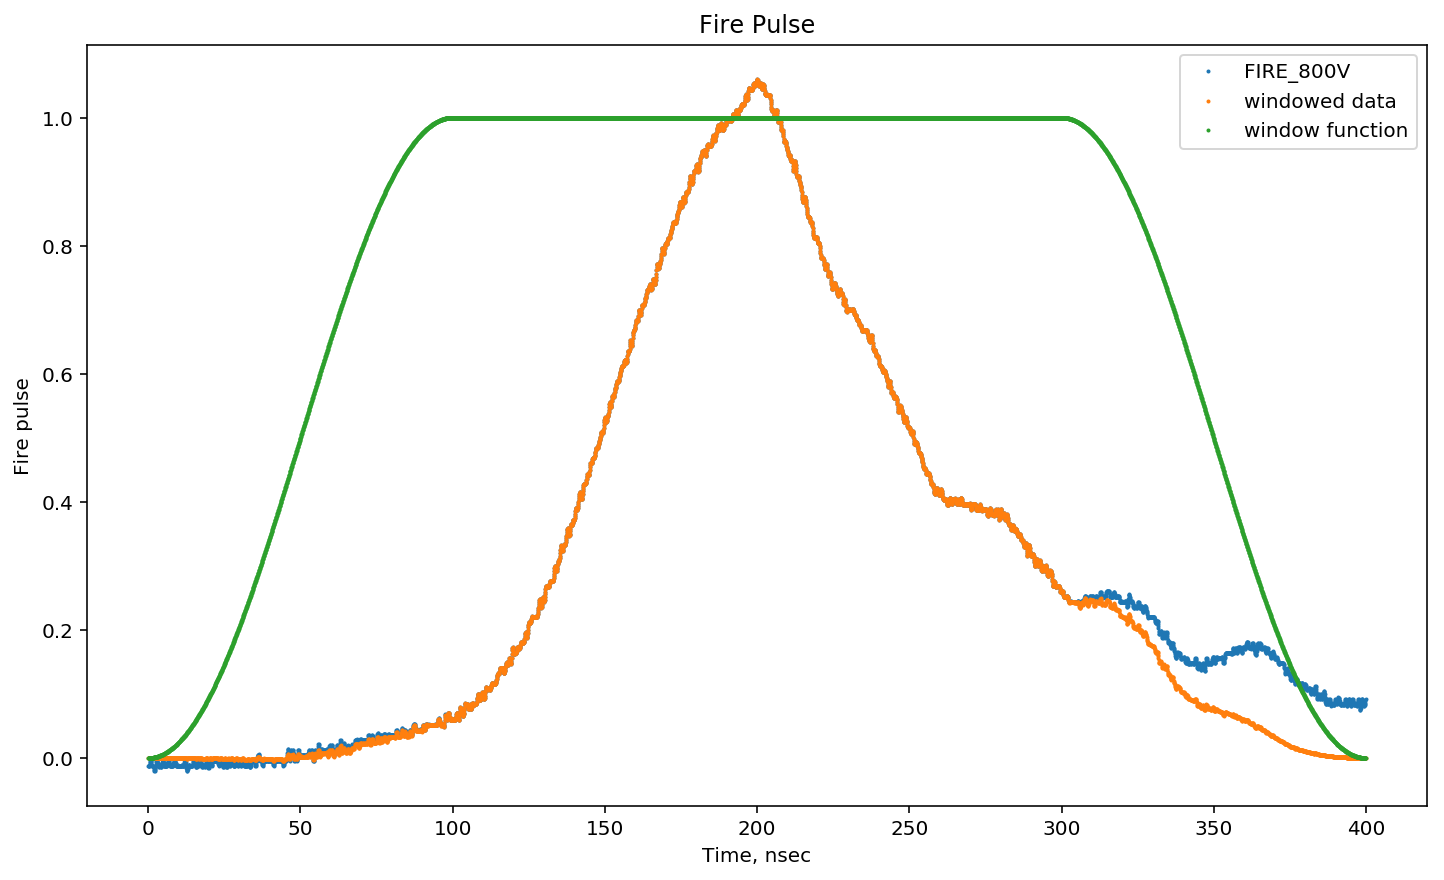

In [133]:
# plot the fire pulse
plt.plot(x1*1e9,y1,'o', markersize=1)
plt.plot(x1*1e9,y1w,'o', markersize=1)
plt.plot(x1*1e9,w,'o', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse')
plt.legend(['FIRE_800V', 'windowed data', 'window function'], loc='best')
plt.title('Fire Pulse')
plt.show()

The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is Hz.

The fft() function computes the one-dimensional n-point discrete Fourier Transform (DFT) of a real-valued array by means of the Fast Fourier Transform (FFT).

In [134]:
sample_freq = scipy.fftpack.fftfreq(n, d=dt)
fft_y1 = scipy.fftpack.fft(y1w)

Plot the data on a semilog scale.  Near 1.25 GHz the noise floor rolls off, perhaps indicating upper limit of the measurement probe’s bandwidth.

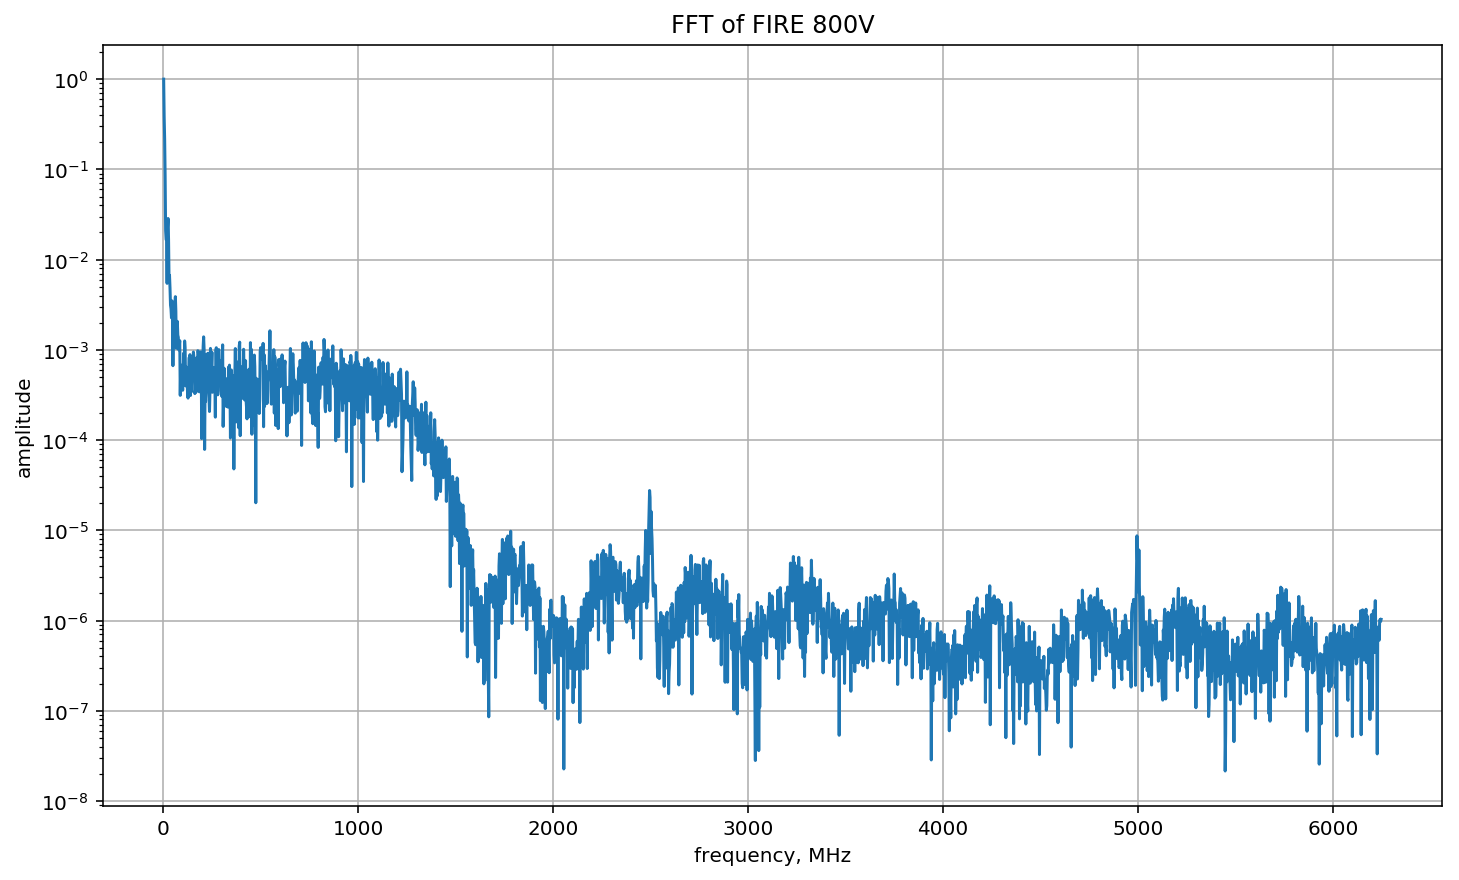

In [135]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude = sample_freq[pidxs], np.abs(fft_y1[pidxs])
amplitude /= amplitude.max()
plt.semilogy(freqs/1e6,amplitude)
plt.ylabel('amplitude')
plt.xlabel('frequency, MHz')
plt.title('FFT of FIRE 800V')
plt.grid()
plt.show()

Plotting the data out to about 2GHz.

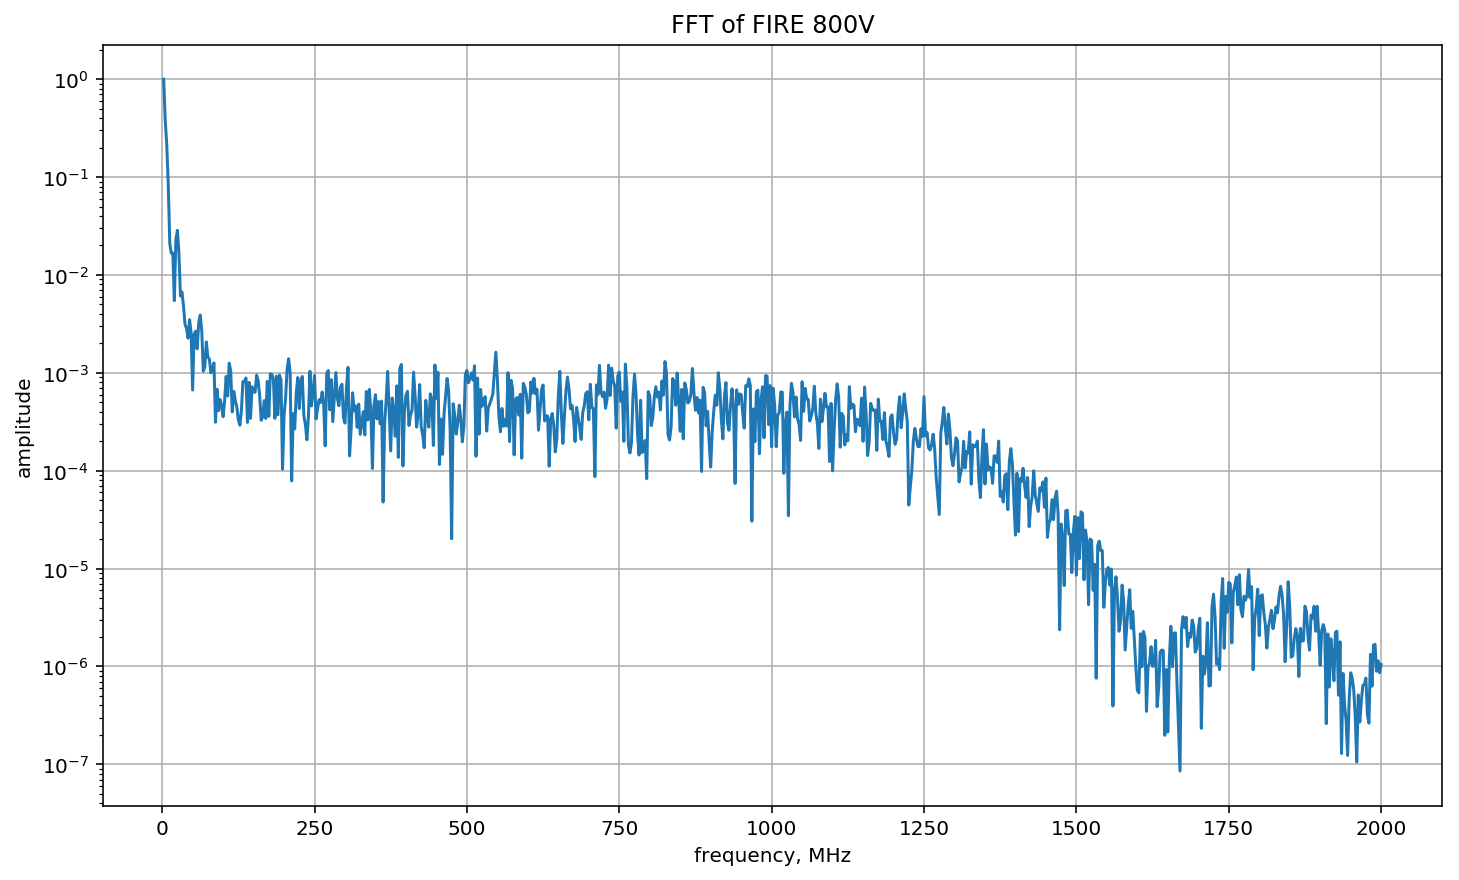

In [136]:
start = 0  #start and ending index, not frequency
end = 800
plt.semilogy(freqs[start:end]/1e6,amplitude[start:end])
plt.ylabel('amplitude')
plt.xlabel('frequency, MHz')
plt.title('FFT of FIRE 800V')
plt.grid()
plt.show()

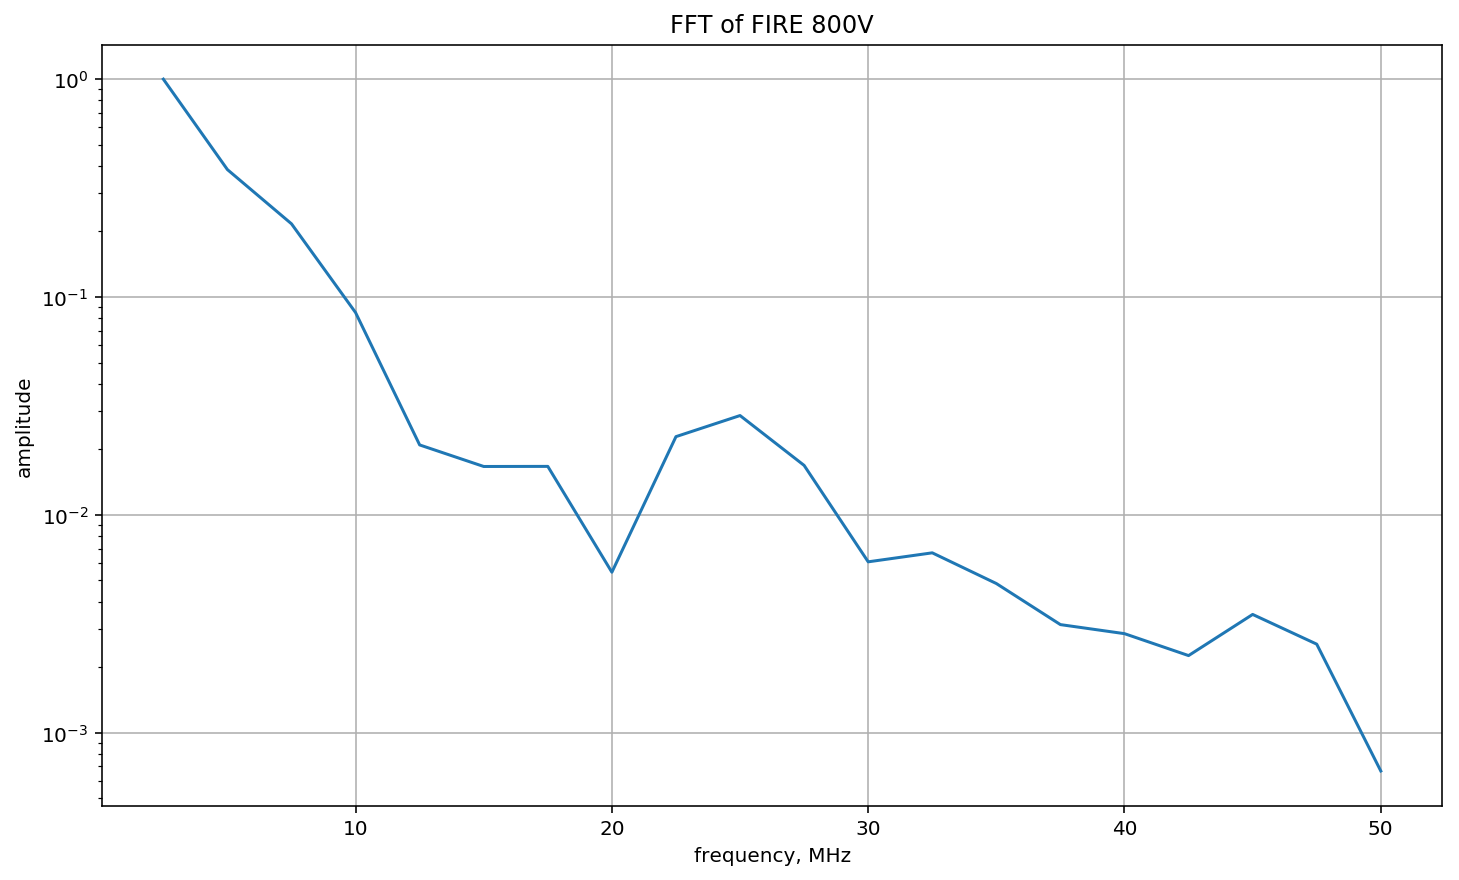

In [137]:
start = 0  #start and ending index, not frequency
end = 20
plt.semilogy(freqs[start:end]/1e6,amplitude[start:end])
plt.ylabel('amplitude')
plt.xlabel('frequency, MHz')
plt.title('FFT of FIRE 800V')
plt.grid()
plt.show()

From the plots above we can see that most of the fire pulse energy is in the lower frequencies.  The frequency bins are 2.5MHz wide and beyond the 5th Fourier coefficient (12.5 MHz) the amplitude is less than about 2% of the peak. This suggests that most of the pulse energy is below 12.5 MHz.  We can integrate across the Fourier coefficients to find the areas in different bands.

The first 5 Fourier coefficients are:

In [138]:
amplitude[0:5]

array([ 1.        ,  0.38443996,  0.21671916,  0.08481506,  0.02094109])

Using numpy's trapezoidal integration function we can compute the area under the spectrum. The power into a resistor is $\frac{v^2}{R}$.  Normalizing R=1, the power is just $v^2$.  The power density is $\frac {v^2}{Hz}$ so we have to square the signal.

In [139]:
end = 3
print('{:.1f}% of the power is below {:.1f}MHz.'.format(100*np.trapz(amplitude[0:end]**2)/np.trapz(amplitude**2),freqs[end]/1e6,))

95.2% of the power is below 10.0MHz.


**CVR test limits:** When using the CVR for testing, test limits can be established based on various calculations.  The voltage across the CVR is proportional to the current flowing through the CVR.  Using Ohm’s law, the peak voltage can be calculated.  The minimum arming voltage on the capacitor should be the maximum all fire voltage, which was determined by the Neyer tests, plus the safety margin of 100 volts.  The maximum arming voltage can be determined by the amount of regulation provided by the switching power supply, the maximum rated voltage for the capacitor and the derating used during the design. The rise time of the fire pulse is limited by the inductance in the fire circuit.  A test limit for the rise time could be determined from the ensemble rise times measured during the Neyer tests.  The Neyer testing included a small penalty from the extra inductance from the strip line extension used during the test. I think for qualification and acceptance testing of the FTSA any rise time shorter than 100 ns was considered passing.

If I have time later, I’ll think about writing a script to process all the Neyer data and calculate some statistics on the pulse waveforms.  All the successful firings could be compared to the no fires. If George sends me the hot and cold Neyer test data, I could analyze the statistics as a function of temperature.

**Conclusions:** The rising edge characteristics of the two fire pulses and the CVR pulse are extremely similar to each other.  Visual inspection of the plotted data as well as the RMSE calculations show a high degree of similarity.  The rise time of the fire pulses analyzed for this study are less than 80 ns.  The 95% power bandwidth of the fire pulse is about 10 MHz.  Based on the calculations in this analysis, the CVR is acceptable to use for acceptance and qualification testing of the FTSA.